<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Event-Logs" data-toc-modified-id="Event-Logs-2">Event Logs</a></span></li><li><span><a href="#Trace-Splitting" data-toc-modified-id="Trace-Splitting-3">Trace Splitting</a></span></li><li><span><a href="#Encoding-Techniques" data-toc-modified-id="Encoding-Techniques-4">Encoding Techniques</a></span><ul class="toc-item"><li><span><a href="#PPObj" data-toc-modified-id="PPObj-4.1">PPObj</a></span></li><li><span><a href="#Categorization" data-toc-modified-id="Categorization-4.2">Categorization</a></span></li><li><span><a href="#Fill-Missing" data-toc-modified-id="Fill-Missing-4.3">Fill Missing</a></span></li><li><span><a href="#Z-score" data-toc-modified-id="Z-score-4.4">Z-score</a></span></li><li><span><a href="#Date-conversion" data-toc-modified-id="Date-conversion-4.5">Date conversion</a></span></li><li><span><a href="#MinMax-Scaling" data-toc-modified-id="MinMax-Scaling-4.6">MinMax Scaling</a></span></li><li><span><a href="#One-HoT-Encoding" data-toc-modified-id="One-HoT-Encoding-4.7">One HoT Encoding</a></span></li></ul></li><li><span><a href="#Sub-sequence-Generation" data-toc-modified-id="Sub-sequence-Generation-5">Sub-sequence Generation</a></span></li><li><span><a href="#Data-Loader" data-toc-modified-id="Data-Loader-6">Data Loader</a></span><ul class="toc-item"><li><span><a href="#Integration-Samples" data-toc-modified-id="Integration-Samples-6.1">Integration Samples</a></span></li></ul></li></ul></div>

In [ ]:
# default_exp preprocessing

Pre-processing
===
This notebook contains all relevant pre-processing. The implementation is based on the tabular notebooks in the fastai library.


In [ ]:
!pip install fastai==2.5.3

In [ ]:
from fastai.torch_basics import *
from fastai.basics import *
from fastai.metrics import accuracy
from fastai.learner import *
from fastai.callback.all import *
from math import sqrt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
MY_WORKSPACE_DIR = "/content/drive/My Drive/BPIC_Data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Event Logs



All considered event logs are stored in `./event_logs`. The `EventLogs` class is a utility class to access each dataset. Logs can be loaded with the function `import_log`.

In [ ]:
class EventLogs:
    Helpdesk=MY_WORKSPACE_DIR + 'Helpdesk.csv'
    BPIC_12=MY_WORKSPACE_DIR + 'BPIC12.csv'
    BPIC_12_W=MY_WORKSPACE_DIR + 'BPIC12_W.csv'
    BPIC_12_Wcomplete=MY_WORKSPACE_DIR + 'BPIC12_Wc.csv'
    BPIC_12_A= MY_WORKSPACE_DIR + 'BPIC12_A.csv'
    BPIC_12_O=MY_WORKSPACE_DIR + 'BPIC12_O.csv'
    BPIC_13_CP=MY_WORKSPACE_DIR + 'BPIC13_CP.csv'
    BPIC_17_OFFER=MY_WORKSPACE_DIR + 'BPIC17_O.csv'
    BPIC_20_RFP=MY_WORKSPACE_DIR + 'BPIC20_RFP.csv'
    Mobis=MY_WORKSPACE_DIR + 'Mobis.csv'

def import_log(ds): return pd.read_csv(ds,index_col=0)

In [ ]:
event_df=import_log(EventLogs.BPIC_12_W)
print(len(event_df))
event_df.head()

170107


,event_id,resource,timestamp,activity,REG_DATE,AMOUNT_REQ
trace_id,,,,,,
173688,0,112.0,2011-09-30 22:39:38.875000+00:00,W_Completeren aanvraag_SCHEDULE,2011-10-01 00:38:44.546000+02:00,20000
173688,1,NaN,2011-10-01 09:36:46.437000+00:00,W_Completeren aanvraag_START,2011-10-01 00:38:44.546000+02:00,20000
173688,2,NaN,2011-10-01 09:45:11.554000+00:00,W_Nabellen offertes_SCHEDULE,2011-10-01 00:38:44.546000+02:00,20000
173688,3,NaN,2011-10-01 09:45:13.917000+00:00,W_Completeren aanvraag_COMPLETE,2011-10-01 00:38:44.546000+02:00,20000
173688,4,NaN,2011-10-01 10:15:41.290000+00:00,W_Nabellen offertes_START,2011-10-01 00:38:44.546000+02:00,20000


## Trace Splitting
i.e. splitting in training, validation and test set

The `split_traces` function is used to split an event_log into training, validation and test set. Furthermore, it removes traces that are longer than a specific threshhold.

In [ ]:
#export
def drop_long_traces(df,max_trace_len=64,event_id='event_id'):
    df=df.drop(np.unique(df[df[event_id]>max_trace_len].index))
    return df

In [ ]:
#export
def RandomTraceSplitter(split_pct=0.2, seed=None):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(trace_ids):
        o=np.unique(trace_ids)
        np.random.seed(seed)
        rand_idx = np.random.permutation(o)
        cut = int(split_pct * len(o))
        return L(rand_idx[cut:].tolist()),L(rand_idx[:cut].tolist())
    return _inner

In [ ]:
#export
def split_traces(df,df_name='tmp',test_seed=42,validation_seed=None):
    df=drop_long_traces(df)
    ts=RandomTraceSplitter(seed=test_seed)
    train,test=ts(df.index)
    ts=RandomTraceSplitter(seed=validation_seed,split_pct=0.1)
    train,valid=ts(train)
    return train,valid,test

In [ ]:
#hide
a1,b1,c1=split_traces(event_df)
a2,b2,c2=split_traces(event_df)
test_ne(a1,a2),test_ne(b1,b2),test_eq(c1,c2);

In [ ]:
#hide
event_df=import_log(EventLogs.BPIC_12_Wcomplete)
event_df.head()

,event_id,resource,timestamp,activity,REG_DATE,AMOUNT_REQ
trace_id,,,,,,
173688,0,NaN,2011-10-01 09:45:13.917000+00:00,W_Completeren aanvraag_COMPLETE,2011-10-01 00:38:44.546000+02:00,20000
173688,1,NaN,2011-10-01 10:17:08.924000+00:00,W_Nabellen offertes_COMPLETE,2011-10-01 00:38:44.546000+02:00,20000
173688,2,10913.0,2011-10-08 14:32:00.886000+00:00,W_Nabellen offertes_COMPLETE,2011-10-01 00:38:44.546000+02:00,20000
173688,3,11049.0,2011-10-10 09:33:05.791000+00:00,W_Nabellen offertes_COMPLETE,2011-10-01 00:38:44.546000+02:00,20000
173688,4,10629.0,2011-10-13 08:37:37.026000+00:00,W_Valideren aanvraag_COMPLETE,2011-10-01 00:38:44.546000+02:00,20000


In [ ]:
#hide
x=split_traces(event_df)
(len(np.unique(event_df.index)),len(sum(x,[])))

(9658, 9651)

## Encoding Techniques
Categorization, Normalization, One-Hot, etc.


### PPObj
an object, that manages the pre-processing and knows date columns, cat columns and cont columns
with a few convenient functions

In [ ]:
#export
class _TraceIloc:
    "Get/set rows by iloc and cols by name"
    def __init__(self,o): self.o = o
    def __getitem__(self, idxs):
        df = self.o.items
        if isinstance(idxs,tuple):
            rows,cols = idxs
            rows=df.index[rows]
            return self.o.new(df.loc[rows,cols])
        else:
            rows,cols = idxs,slice(None)
            rows=np.unique(df.index)[rows]
            return self.o.new(df.loc[rows])

In [ ]:
#export
class PPObj(CollBase, GetAttr, FilteredBase):
    "Main Class for Process Prediction"
    _default,with_cont='procs',True
    def __init__(self,df,procs=None,cat_names=None,cont_names=None,date_names=None,y_names=None,splits=None,
                 ycat_names=None,ycont_names=None,inplace=False,do_setup=True):
        if not inplace: df=df.copy()
        if splits is not None: df = df.loc[sum(splits, [])] # Can drop traces
        self.event_ids=df['event_id'].values if hasattr(df,'event_id') else None

        super().__init__(df)

        self.cat_names,self.cont_names,self.date_names=(L(cat_names),L(cont_names),L(date_names))
        self.set_y_names(y_names,ycat_names,ycont_names)

        self.procs = Pipeline(procs)
        self.splits=splits
        if do_setup: self.setup()


    @property
    def y_names(self): return self.ycat_names+self.ycont_names

    def set_y_names(self,y_names,ycat_names=None,ycont_names=None):
        if ycat_names or ycont_names: store_attr('ycat_names,ycont_names')
        else:
            self.ycat_names,self.ycont_names=(L([i for i in L(y_names) if i in self.cat_names]),
                                                L([i for i in L(y_names) if i not in self.cat_names]))
    def setup(self): self.procs.setup(self)
    def subset(self, i): return self.new(self.loc[self.splits[i]]) if self.splits else self
    def __len__(self): return len(np.unique(self.items.index))
    def show(self, max_n=3, **kwargs):
        print('#traces:',len(self),'#events:',len(self.items))
        display_df(self.new(self.all_cols[:max_n]).items)
    def new(self, df):
        return type(self)(df, do_setup=False,
                          **attrdict(self, 'procs','cat_names','cont_names','ycat_names','ycont_names',
                                     'date_names'))
    def process(self): self.procs(self)
    def loc(self): return self.items.loc
    def iloc(self): return _TraceIloc(self)
    def x_names (self): return self.cat_names + self.cont_names
    def all_col_names(self): return ((self.x_names+self.y_names)).unique()
    def transform(self, cols, f, all_col=True):
        if not all_col: cols = [c for c in cols if c in self.items.columns]
        if len(cols) > 0: self[cols] = self[cols].transform(f)
    def new_empty(self): return self.new(pd.DataFrame({}, columns=self.items.columns))
    def subsets(self): return [self.subset(i) for i in range(len(self.splits))] if self.splits else L(self)
properties(PPObj,'loc','iloc','x_names','all_col_names')

def _add_prop(cls, nm):
    @property
    def f(o): return o[list(getattr(o,nm+'_names'))]
    @f.setter
    def fset(o, v): o[getattr(o,nm+'_names')] = v
    setattr(cls, nm+'s', f)
    setattr(cls, nm+'s', fset)

_add_prop(PPObj, 'cat')
_add_prop(PPObj, 'cont')
_add_prop(PPObj, 'ycat')
_add_prop(PPObj, 'ycont')
_add_prop(PPObj, 'y')
_add_prop(PPObj, 'x')
_add_prop(PPObj, 'all_col')

In [ ]:
ppObj=PPObj(event_df,cat_names=['activity', 'resource'],y_names=['activity'])

In [ ]:
ppObj.ycat_names

(#1) ['activity']

In [ ]:
ppObj.iloc[0].show() # shows first trace

#traces: 1 #events: 5


,activity,resource
trace_id,,
173688,W_Completeren aanvraag_COMPLETE,NaN
173688,W_Nabellen offertes_COMPLETE,NaN
173688,W_Nabellen offertes_COMPLETE,10913.0


We can define various pre-processing functions that are executed, when `PPOBj` is instantiated. `PPProc` is the base class for a pre-processing function. It ensures, that setup of a pre-processing function is performed using the training set, and than it is applied to the validation and test set, with the same parameters.

In [ ]:
#export
class PPProc(InplaceTransform):
    "Base class to write a non-lazy tabular processor for dataframes"
    def setup(self, items=None, train_setup=False): #TODO: properly deal with train_setup
        super().setup(getattr(items,'train',items), train_setup=False)
        #super().setup(items, train_setup=False)

        # Procs are called as soon as data is available
        return self(items.items if isinstance(items,Datasets) else items)

    @property
    def name(self): return f"{super().name} -- {getattr(self,'__stored_args__',{})}"

### Categorization
i.e ordinal encoding

Implementation of ordinal or integer encoding. Adds NA values for unknown data. Implementation is pretty much taken from fastai.

In [ ]:
#export
def _apply_cats (voc, add, c):
    if not is_categorical_dtype(c):
        return pd.Categorical(c, categories=voc[c.name][add:]).codes+add
    return c.cat.codes+add #if is_categorical_dtype(c) else c.map(voc[c.name].o2i)

def _decode_cats(voc, c): 
  print(voc)
  return c.map(dict(enumerate(voc[c.name].items)))


In [ ]:
#export
class Categorify(PPProc):
    "Transform the categorical variables to something similar to `pd.Categorical`"
    order = 2
    def setups(self, to):
        store_attr(classmaps={n:dict(enumerate(CategoryMap(to.items.loc[:,n], add_na=False))) for n in to.cat_names}, but='to')
        store_attr(classes={n:CategoryMap(to.items.loc[:,n], add_na=False) for n in to.cat_names}, but='to')
    def encodes(self, to):
        to.transform(to.cat_names, partial(_apply_cats, self.classes, 1))

    def decodes(self, to): to.transform(to.cat_names, partial(_decode_cats, self.classes))
    def __getitem__(self,k): return self.classes[k]

In [ ]:
log=import_log(EventLogs.BPIC_12)
traces=split_traces(log)[0][:100]
splits=traces[:60],traces[60:80],traces[80:100]
o=PPObj(log,None,cat_names=['activity', 'resource'],splits=splits)

In [ ]:
m=CategoryMap(o.items.loc[:,'activity'])
print(dict( enumerate(m ) ) )


{0: 'A_ACCEPTED_COMPLETE', 1: 'A_ACTIVATED_COMPLETE', 2: 'A_APPROVED_COMPLETE', 3: 'A_CANCELLED_COMPLETE', 4: 'A_DECLINED_COMPLETE', 5: 'A_FINALIZED_COMPLETE', 6: 'A_PARTLYSUBMITTED_COMPLETE', 7: 'A_PREACCEPTED_COMPLETE', 8: 'A_REGISTERED_COMPLETE', 9: 'A_SUBMITTED_COMPLETE', 10: 'O_ACCEPTED_COMPLETE', 11: 'O_CANCELLED_COMPLETE', 12: 'O_CREATED_COMPLETE', 13: 'O_DECLINED_COMPLETE', 14: 'O_SELECTED_COMPLETE', 15: 'O_SENT_BACK_COMPLETE', 16: 'O_SENT_COMPLETE', 17: 'W_Afhandelen leads_COMPLETE', 18: 'W_Afhandelen leads_SCHEDULE', 19: 'W_Afhandelen leads_START', 20: 'W_Beoordelen fraude_COMPLETE', 21: 'W_Beoordelen fraude_SCHEDULE', 22: 'W_Beoordelen fraude_START', 23: 'W_Completeren aanvraag_COMPLETE', 24: 'W_Completeren aanvraag_SCHEDULE', 25: 'W_Completeren aanvraag_START', 26: 'W_Nabellen incomplete dossiers_COMPLETE', 27: 'W_Nabellen incomplete dossiers_SCHEDULE', 28: 'W_Nabellen incomplete dossiers_START', 29: 'W_Nabellen offertes_COMPLETE', 30: 'W_Nabellen offertes_SCHEDULE', 31: 'W

In [ ]:
cat=Categorify()
cat.setup(o)
cat.classmaps

{'activity': {0: 'A_ACCEPTED_COMPLETE',
  1: 'A_ACTIVATED_COMPLETE',
  2: 'A_APPROVED_COMPLETE',
  3: 'A_CANCELLED_COMPLETE',
  4: 'A_DECLINED_COMPLETE',
  5: 'A_FINALIZED_COMPLETE',
  6: 'A_PARTLYSUBMITTED_COMPLETE',
  7: 'A_PREACCEPTED_COMPLETE',
  8: 'A_REGISTERED_COMPLETE',
  9: 'A_SUBMITTED_COMPLETE',
  10: 'O_ACCEPTED_COMPLETE',
  11: 'O_CANCELLED_COMPLETE',
  12: 'O_CREATED_COMPLETE',
  13: 'O_DECLINED_COMPLETE',
  14: 'O_SELECTED_COMPLETE',
  15: 'O_SENT_BACK_COMPLETE',
  16: 'O_SENT_COMPLETE',
  17: 'W_Afhandelen leads_COMPLETE',
  18: 'W_Afhandelen leads_SCHEDULE',
  19: 'W_Afhandelen leads_START',
  20: 'W_Beoordelen fraude_COMPLETE',
  21: 'W_Beoordelen fraude_SCHEDULE',
  22: 'W_Beoordelen fraude_START',
  23: 'W_Completeren aanvraag_COMPLETE',
  24: 'W_Completeren aanvraag_SCHEDULE',
  25: 'W_Completeren aanvraag_START',
  26: 'W_Nabellen incomplete dossiers_COMPLETE',
  27: 'W_Nabellen incomplete dossiers_SCHEDULE',
  28: 'W_Nabellen incomplete dossiers_START',
  29: 'W_

In [ ]:
log=import_log(EventLogs.BPIC_12)
o=PPObj(log,Categorify,'activity')

### Fill Missing
for continuous values

A pre-processing function that deals with missing data in continuous attributes. Missing data can be replaced with the median, mean or a constant value. Additionaly, we can create another boolean column that indicates, which rows were missing.  Implementation is pretty much taken from fastai.

In [ ]:
#export
class FillStrategy:
    "Namespace containing the various filling strategies."
    def median  (c,fill): return c.median()
    def constant(c,fill): return fill
    def mode    (c,fill): return c.dropna().value_counts().idxmax()

In [ ]:
#export
class FillMissing(PPProc):
    order=1
    "Fill the missing values in continuous columns."
    def __init__(self, fill_strategy=FillStrategy.median, add_col=True, fill_vals=None):
        if fill_vals is None: fill_vals = defaultdict(int)
        store_attr()

    def setups(self, dsets):
        missing = pd.isnull(dsets.conts).any()
        store_attr(but='to', na_dict={n:self.fill_strategy(dsets[n], self.fill_vals[n])
                            for n in missing[missing].keys()})
        self.fill_strategy = self.fill_strategy.__name__

    def encodes(self, to):
        missing = pd.isnull(to.conts)
        for n in missing.any()[missing.any()].keys():
            assert n in self.na_dict, f"nan values in `{n}` but not in setup training set"
        for n in self.na_dict.keys():
            to[n].fillna(self.na_dict[n], inplace=True)
            if self.add_col:
                to.loc[:,n+'_na'] = missing[n]
                if n+'_na' not in to.cat_names: to.cat_names.append(n+'_na')

In [ ]:
fill = FillMissing() 
df = pd.DataFrame({'a':[0,1,np.nan,1,2,3,4], 'b': [0,1,2,3,4,5,6]})
to = PPObj(df, fill, cont_names=['a', 'b'])
to.show()

#traces: 7 #events: 7


,a_na,a,b
0,False,0.0,0
1,False,1.0,1
2,True,1.5,2


### Z-score

Calculates standartization, also known as z-score formula. Copied from fastai.

In [ ]:
#export
class Normalize(PPProc):
    "Normalize with z-score"
    order = 3
    def setups(self, to):
        store_attr(but='to', means=dict(getattr(to, 'train', to).conts.mean()),
                   stds=dict(getattr(to, 'train', to).conts.std(ddof=0)+1e-7))
        return self(to)

    def encodes(self, to): to.conts = (to.conts-self.means) / self.stds
    def decodes(self, to): to.conts = (to.conts*self.stds ) + self.means

In [ ]:
event_df.head()

,event_id,resource,timestamp,activity,REG_DATE,AMOUNT_REQ
trace_id,,,,,,
173688,0,NaN,2011-10-01 09:45:13.917000+00:00,W_Completeren aanvraag_COMPLETE,2011-10-01 00:38:44.546000+02:00,20000
173688,1,NaN,2011-10-01 10:17:08.924000+00:00,W_Nabellen offertes_COMPLETE,2011-10-01 00:38:44.546000+02:00,20000
173688,2,10913.0,2011-10-08 14:32:00.886000+00:00,W_Nabellen offertes_COMPLETE,2011-10-01 00:38:44.546000+02:00,20000
173688,3,11049.0,2011-10-10 09:33:05.791000+00:00,W_Nabellen offertes_COMPLETE,2011-10-01 00:38:44.546000+02:00,20000
173688,4,10629.0,2011-10-13 08:37:37.026000+00:00,W_Valideren aanvraag_COMPLETE,2011-10-01 00:38:44.546000+02:00,20000


In [ ]:
df = pd.DataFrame({'a':[0,1,9,3,4]})
to = PPObj(df, Normalize(), cont_names='a')
to.show()

#traces: 5 #events: 5


,a
0,-1.429409
1,-1.327783
2,-0.514775


### Date conversion

Encodes a date column. Supports multiple information by using pandas date functions. This implementation is also based on the fastai but also supports relative duration from the first event of a case.

In [ ]:
#export
def _make_date(df, date_field):
    "Make sure `df[date_field]` is of the right date type."
    field_dtype = df[date_field].dtype
    if isinstance(field_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        field_dtype = np.datetime64
    if not np.issubdtype(field_dtype, np.datetime64):
        df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True,utc=True)

In [ ]:
df = pd.DataFrame({'fu': ['2019-12-04', '2019-11-29', '2019-11-15', '2019-10-24']})
_make_date(df, 'fu')
df.dtypes

fu    datetime64[ns, UTC]
dtype: object

In [ ]:
#export
def _secSinceSunNoon(datTimStr):
    dt = pd.to_datetime(datTimStr).dt
    return (dt.dayofweek-1)*24*3600+ dt.hour * 3600 + dt.minute * 60 + dt.second

In [ ]:
#export
def _secSinceNoon(datTimStr):
    dt = pd.to_datetime(datTimStr).dt
    return dt.hour * 3600 + dt.minute * 60 + dt.second

In [ ]:
#export
Base_Date_Encodings=['Year', 'Month', 'Day', 'Dayofweek', 'Dayofyear','Elapsed']

In [ ]:
#export
def encode_date(df, field_name,unit=1e9,date_encodings=Base_Date_Encodings):
    "Helper function that adds columns relevant to a date in the column `field_name` of `df`."
    _make_date(df, field_name)
    field = df[field_name]
    prefix =  re.sub('[Dd]ate$', '', field_name+"_")
    attr = ['Year', 'Month', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr:
        if n in date_encodings: df[prefix + n] = getattr(field.dt, n.lower())
    # Pandas removed `dt.week` in v1.1.10

    if 'secSinceSunNoon' in date_encodings:
        df[prefix+'secSinceSunNoon']=_secSinceSunNoon(field)
    if 'secSinceNoon' in date_encodings:
        df[prefix+'secSinceNoon']=_secSinceNoon(field)
    if 'Week' in date_encodings:
        week = field.dt.isocalendar().week if hasattr(field.dt, 'isocalendar') else field.dt.week
        df.insert(3, prefix+'Week', week)
    mask = ~field.isna()
    elapsed = pd.Series(np.where(mask,field.values.astype(np.int64) // unit,None).astype(float),index=field.index)

    if 'Relative_elapsed' in date_encodings:
        df[prefix+'Relative_elapsed']=elapsed-elapsed.groupby(elapsed.index).transform('min')

    # required to decode!
    if 'Elapsed' in date_encodings: df[prefix+'Elapsed']=elapsed

    df.drop(field_name, axis=1, inplace=True)
    return [],[prefix+i for i in date_encodings]

In [ ]:
df = pd.DataFrame({'fu': ['2019-12-04', '2019-11-29', '2019-11-15', '2019-10-24']})
encode_date(df,'fu')
df

,fu_Year,fu_Month,fu_Day,fu_Dayofweek,fu_Dayofyear,fu_Elapsed
0,2019,12,4,2,338,1.575418e+09
1,2019,11,29,4,333,1.574986e+09
2,2019,11,15,4,319,1.573776e+09
3,2019,10,24,3,297,1.571875e+09


In [ ]:
#export
def decode_date(df, field_name,unit=1e9,date_encodings=Base_Date_Encodings):
    df[field_name]=(df[field_name+'_'+'Elapsed'] * unit).astype('datetime64[ns, UTC]')
    for c in date_encodings: del df[field_name+'_'+c]

In [ ]:
decode_date(df,'fu')
df

,fu
0,2019-12-04 00:00:00+00:00
1,2019-11-29 00:00:00+00:00
2,2019-11-15 00:00:00+00:00
3,2019-10-24 00:00:00+00:00


In [ ]:
#export
class Datetify(PPProc):
    "Encode dates, "
    order = 0

    def __init__(self, date_encodings=['Relative_elapsed']): self.date_encodings=listify(date_encodings)

    def encodes(self, o):
        for i in o.date_names:
            cat,cont=encode_date(o.items,i,date_encodings=self.date_encodings)
            o.cont_names+=cont
            o.cat_names+=cat
# Todo: Add decoding

In [ ]:
df = pd.DataFrame({'fu': ['2019-10-04', '2019-10-09', '2019-10-15', '2019-10-24']},index=[1,1,1,1])
o = PPObj(df,Datetify(date_encodings=['secSinceSunNoon','secSinceNoon','Relative_elapsed']),date_names='fu')
o.xs

,fu_secSinceSunNoon,fu_secSinceNoon,fu_Relative_elapsed
1,259200,0,0.0
1,86400,0,432000.0
1,0,0,950400.0
1,172800,0,1728000.0


### MinMax Scaling

Calculates the MinMax scaling from a column.

In [ ]:
#export
class MinMax(PPProc):
    order=3

    def setups(self, o):
        store_attr(mins=o.xs.min(),
                   maxs=o.xs.max())

    def encodes(self, o):
        cols=[i+'_minmax' for i in o.x_names]
        o[cols] = o.xs.astype(float)
        o[cols] = ((o.xs-self.mins) /(self.maxs-self.mins))
        o.cont_names=L(cols)
        o.cat_names=L()

In [ ]:
event_df=import_log(EventLogs.Mobis)

In [ ]:
o=PPObj(event_df,[Categorify,MinMax,Datetify,FillMissing],cont_names=['cost'],cat_names=['activity'])

In [ ]:
o.xs.max()

activity_minmax    1.0
cost_na_minmax     1.0
cost_minmax        1.0
dtype: float64

In [ ]:
event_df=import_log(EventLogs.BPIC_12)

In [ ]:
PPObj(event_df,[Categorify(),Datetify(),MinMax()],
      date_names=['timestamp'],cat_names=['activity','resource'],cont_names=['AMOUNT_REQ']).show(max_n=5)

#traces: 13087 #events: 262200


,activity_minmax,resource_minmax,AMOUNT_REQ_minmax,timestamp_Relative_elapsed_minmax
trace_id,,,,
173688,0.257143,0.0,0.200002,0.000000
173688,0.171429,0.0,0.200002,0.000000
173688,0.200000,0.0,0.200002,0.000004
173688,0.685714,0.0,0.200002,0.000005
173688,0.714286,0.0,0.200002,0.003330


### One HoT Encoding

Calculates the one-hot encoding of a column. It is required to first apply categorization on the same column, to deal with missing values.

In [ ]:
#export
from sklearn.preprocessing import OneHotEncoder

In [ ]:
o=PPObj(event_df,[Categorify],cat_names=['activity','resource'])

In [ ]:
len(o.xs),len(o.procs.categorify['activity'])

(262200, 36)

In [ ]:
o.xs.values

array([[ 9,  0],
       [ 6,  0],
       [ 7,  0],
       ...,
       [19, 48],
       [ 4, 48],
       [17, 48]], dtype=int8)

In [ ]:
x=o.xs.to_numpy()
categories=[range(len(o.procs.categorify['activity'])),range(len(o.procs.categorify['activity']))]

In [ ]:
x=np.array(['a1','a2'])
categories=[['a1','a2','a3']]

In [ ]:
ohe = OneHotEncoder(categories=categories)
a=ohe.fit_transform(x.reshape(-1, 1)).toarray()
a.shape

(2, 3)

In [ ]:
categories=['a1','a2','a3']

In [ ]:
#export
#export
from sklearn.preprocessing import OneHotEncoder
class OneHot(PPProc):
    "Transform the categorical variables to one-hot. Requires Categorify to deal with unseen data."
    order = 3

    def encodes(self, o):
        new_cats=[]
        for c in o.cat_names:
            categories=[range(len(o.procs.categorify[c]))]
            x=o[c].to_numpy()
            ohe = OneHotEncoder(categories=categories)
            enc=ohe.fit_transform(x.reshape(-1, 1)).toarray()
            for i in range(enc.shape[1]):
                new_cat=f'{c}_{i}'
                o.items.loc[:,new_cat]=enc[:,i]
                new_cats.append(new_cat)
        o.cat_names=L(new_cats)

In [ ]:
event_df=import_log(EventLogs.BPIC_17_OFFER)

In [ ]:
%%time
o=PPObj(event_df,[Categorify(),OneHot()],cat_names=['activity','resource'])

CPU times: user 10.8 s, sys: 983 ms, total: 11.8 s
Wall time: 11.7 s


## Sub-sequence Generation

Here, the log dataframe is converted into subsequences or prefices of the cases. For a case with n events, we create n prefixes. The prefix generation is done in an efficient way, through the `np.roll` function, which shifts a numpy array by 1 element.

In [ ]:
#export
def _shift_columns (a,ws=3): return np.dstack(list(reversed([np.roll(a,i) for i in range(0,ws)])))[0]

In [ ]:
#export
def subsequences_fast(df,event_ids,ws=None,min_ws=64):
    max_trace_len=int(event_ids.max())+1

    if not ws: ws=max_trace_len-1
    elif ws <max_trace_len-1: raise ValueError(f"ws must be greater equal {max_trace_len-1}")
    pad=ws
    ws=max(min_ws,ws)
    trace_start = np.where(event_ids == 0)[0]
    trace_len=np.array([trace_start[i]-trace_start[i-1] for i in range(1,len(trace_start))]+[len(df)-trace_start[-1]])
    tmp=np.stack([_shift_columns(df[i],ws=ws) for i in list(df)])
    idx=[range(trace_start[i],trace_start[i]+trace_len[i]-1) for i in range(len(trace_start))]
    idx=np.array([y for x in idx for y in x])

    res=np.rollaxis(tmp,1)[idx]
    mask=ws-1-event_ids[idx][:,None] > np.arange(res.shape[2])
    res[np.broadcast_to(mask[:,None],res.shape)]=0
    return res,idx+1

In [ ]:
event_df=import_log(EventLogs.BPIC_12)

In [ ]:
o=PPObj(event_df,Categorify(),cat_names=['activity'],y_names='activity')
#o=o.iloc[0]
len(o)

13087

In [ ]:
len(o.items)-len(o)

249113

In [ ]:
ws,idx=subsequences_fast(o.xs,o.event_ids,min_ws=14)
ws,ws.shape

(array([[[ 0,  0,  0, ...,  0,  0,  9]],
 
        [[ 0,  0,  0, ...,  0,  9,  6]],
 
        [[ 0,  0,  0, ...,  9,  6,  7]],
 
        ...,
 
        [[ 0,  0,  0, ...,  9,  6, 18]],
 
        [[ 0,  0,  0, ...,  6, 18, 19]],
 
        [[ 0,  0,  0, ..., 18, 19,  4]]], dtype=int8), (249113, 1, 174))

## Data Loader

The prefixes are converted to a `pytorch.Dataset` and than to a `DataLoader`
A batch is than represented as a tuple of the form `(x cat. attr,x cont. attr, y cat. attr., y cont attr.)`. Also, categorical attributes are converted to a long tensor and continous attributes to a float tensor.

If a dimensions of the batch is empty - e.g. the model does not use categorical input attributes - it is removed from the tuple. 

In [ ]:
o=PPObj(event_df,Categorify(),cat_names=['activity'],y_names='activity')
ws,idx=subsequences_fast(o.xs,o.event_ids,min_ws=0)
ws,ws.shape

(array([[[ 0,  0,  0, ...,  0,  0,  9]],
 
        [[ 0,  0,  0, ...,  0,  9,  6]],
 
        [[ 0,  0,  0, ...,  9,  6,  7]],
 
        ...,
 
        [[ 0,  0,  0, ...,  9,  6, 18]],
 
        [[ 0,  0,  0, ...,  6, 18, 19]],
 
        [[ 0,  0,  0, ..., 18, 19,  4]]], dtype=int8), (249113, 1, 174))

In [ ]:
#export
class PPDset(torch.utils.data.Dataset):
    def __init__(self, inp):
        store_attr('inp')

    def __len__(self): return len(self.inp[0])

    def __getitem__(self, idx):
        xs=tuple([i[idx]for i in self.inp[:-1]])
        ys=tuple([i[idx]for i in self.inp[-1]])
        if len(ys)==1: ys=ys[0]
        return (*xs,ys)

In [ ]:
o=PPObj(event_df,Categorify(),cat_names=['activity','resource'],y_names='activity',splits=split_traces(event_df))

subs = o.subsets()
s=subs[0]
wds,idx=subsequences_fast(s.xs,s.event_ids)
y=s.ys.iloc[idx]
ycats=tensor(y[s.ycat_names].values).long()
yconts=tensor(y[s.ycont_names].values).float()
xconts=tensor(wds[:,len(s.cat_names):]).float()
xcats=tensor(wds[:,:len(s.cat_names)]).long()
xs=tuple([i for i in [xcats,xconts] if i.shape[1]>0])
ys=[ycats[:,i] for i in range(ycats.shape[1])] + [yconts[:,i] for i in range(yconts.shape[1])]


print(ys)
yes = ys[0].detach().cpu().numpy()
print(yes)
clsnames = o.classmaps

act_names = clsnames['activity']
replaced_list = [x if x not in act_names else act_names[x] for x in yes]
print(replaced_list[:10])

dt_plot =  pd.DataFrame(replaced_list, columns=['activity'])
df = dt_plot.value_counts(sort=True).reset_index(name='counts')
df


In [ ]:
#export
@delegates(TfmdDL)
def get_dls(ppo:PPObj,windows=subsequences_fast,outcome=False,event_id='event_id',bs=64,**kwargs):
    ds=[]
    for s in ppo.subsets():
        wds,idx=windows(s.xs,s.event_ids)

        if not outcome: y=s.ys.iloc[idx]
        else: y=s.ys.groupby(s.items.index).transform('last').iloc[idx]
        ycats=tensor(y[s.ycat_names].values).long()
        yconts=tensor(y[s.ycont_names].values).float()
        xconts=tensor(wds[:,len(s.cat_names):]).float()
        xcats=tensor(wds[:,:len(s.cat_names)]).long()
        xs=tuple([i.squeeze() for i in [xcats,xconts] if i.shape[1]>0])
        ys=tuple([ycats[:,i] for i in range(ycats.shape[1])])+tuple([yconts[:,i] for i in range(yconts.shape[1])])
        ds.append(PPDset((*xs,ys)))
    return DataLoaders.from_dsets(*ds,bs=bs,**kwargs)
PPObj.get_dls= get_dls

In [ ]:
dls=o.get_dls()
xb,yb=dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 2, 64]), torch.Size([64]))

### Integration Samples

This section shows, how the PPObj can be used to create a DataLoader for pedictive process analytics:

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sample-Training" data-toc-modified-id="Sample-Training-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sample Training</a></span></li><li><span><a href="#Process-Prediction-Model" data-toc-modified-id="Process-Prediction-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Process Prediction Model</a></span></li><li><span><a href="#Pipeline-Runner" data-toc-modified-id="Pipeline-Runner-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pipeline Runner</a></span></li></ul></div>

In [ ]:
# default_exp pipeline

Pipeline
===



In [ ]:

import pickle

## Sample Training

This section introduces a sample training, whith an simple recurrent pytorch model on the task next activity prediction.

In [ ]:
log=import_log(EventLogs.BPIC_12)

In [ ]:
col='resource'
o=PPObj(log,procs=Categorify(),cat_names=col,y_names=col,splits=split_traces(log))
o.show()
print(len(splits[0]), len(splits[1]), len(splits[2]))

#traces: 12658 #events: 226617


,resource
trace_id,
210605,0
210605,0
210605,0


60 20 20


In [ ]:
dls=o.get_dls()
print(len(dls[0]))
xb,yb=dls.one_batch()
xb.shape,yb.shape

2416


(torch.Size([64, 64]), torch.Size([64]))

In [ ]:
xb[0]

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0, 12,  3,  3,  3])

In [ ]:
len(o.procs.categorify[col])

23

In [ ]:
#export
class RNNwEmbedding(torch.nn.Module) :
    def __init__(self,o) :
        super().__init__()
        vocab_size=len(o.procs.categorify[o.y_names[0]])
        emb_size = int(sqrt(vocab_size))+1
        hidden_six = 20
        self.emb = nn.Embedding(vocab_size,emb_size)

        self.rnn = nn.RNN(emb_size, hidden_six, batch_first=True, num_layers=2)

        self.linear = nn.Linear(hidden_six, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x,_ = self.rnn(x)
        x = x[:,-1]
        x = self.linear(x)
        x = F.softmax(x,dim=1)
        return x

In [ ]:
m=RNNwEmbedding(o)
p=m(xb)

In [ ]:
#export
class HideOutput:
    'A utility function that hides all outputs in a context'
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [ ]:
#export
def training_loop(learn,epoch,print_output,lr_find):
    '''
    Basic training loop that uses learning rate finder and one cycle training. 
    See fastai docs for more information
    '''
    if lr_find:
        lr=np.median([learn.lr_find(show_plot=print_output)[0] for i in range(5)])
        learn.fit_one_cycle(epoch,float(lr))
    else: learn.fit(epoch,0.01)

In [ ]:
#export
from fastai.imports import *
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'


def train_validate(dls,m,metrics=accuracy,loss=F.cross_entropy,epoch=20,print_output=True,model_dir=".",lr_find=True,
                   output_index=1,patience=3,min_delta=0.005,show_plot=True,store_path='tmp',model_name='.model'):
    '''
    Trains a model on the training set with early stopping based on the validation loss.
    Afterwards, applies it to the test set.
    '''
    cbs = [EarlyStoppingCallback(monitor='valid_loss',min_delta=min_delta, patience=patience),
      SaveModelCallback(fname=model_name)
      ]
    learn=Learner(dls, m, path=store_path, model_dir=model_dir, loss_func=loss ,metrics=metrics,cbs=cbs)

    if print_output:
        training_loop(learn,epoch,show_plot,lr_find=lr_find)
        print('validation')
        temp=learn.validate(dl=dls[2])#[output_index]
        preds, actual = learn.get_preds(dl=dls[2])
        return preds, actual
    else:
        with HideOutput(),learn.no_bar(),learn.no_logging():
            training_loop(learn,epoch,show_plot,lr_find=lr_find)
            temp = learn.validate(dl=dls[2])[output_index]
            preds, actual = learn.get_preds(dl=dls[2])
            return preds, actual

In [ ]:
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
log=import_log(EventLogs.BPIC_12)
cols,outcome='activity',False
o=PPObj(log,procs=Categorify(),cat_names=cols,y_names=cols,splits=split_traces(log))
olabels = list(o.classmaps['activity'].values())
dls=o.get_dls(outcome=outcome,windows=partial(subsequences_fast,min_ws=0))
print(len(dls[2]))
xcat,y =dls[2].one_batch()
plen =  torch.count_nonzero(xcat, dim=1)
print( len(plen))

#cm = confusion_matrix(actual, predicted)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=olabels)
#disp.plot()
#plt.show()

659
64


epoch,train_loss,valid_loss,accuracy,time
0,2.824809,2.819656,0.810726,01:01
1,2.819599,2.815983,0.813741,01:15


Better model found at epoch 0 with valid_loss value: 2.8196561336517334.
Better model found at epoch 1 with valid_loss value: 2.8159825801849365.


Better model found at epoch 0 with valid_loss value: 0.8126245141029358.


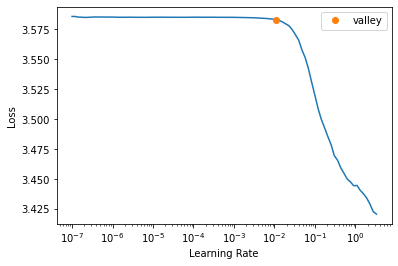

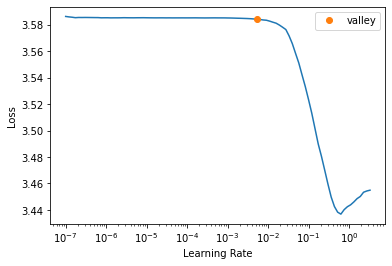

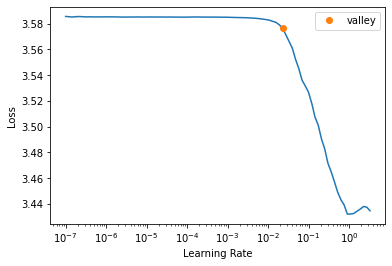

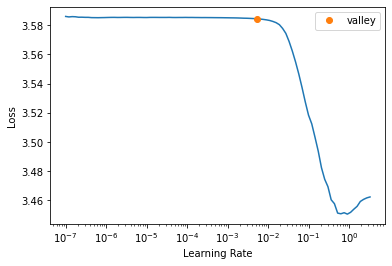

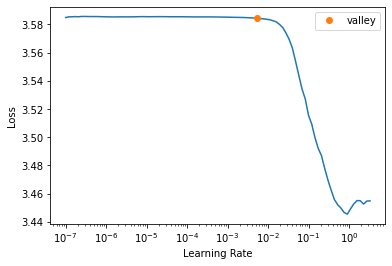

In [ ]:
m=RNNwEmbedding(o)
preds, actual = train_validate(dls,m,epoch=2)
predicted = torch.argmax(preds, dim=1)
actual = actual.detach().cpu().numpy()
predicted = predicted.detach().cpu().numpy()

In [ ]:
from sklearn.metrics import classification_report
print(cm)
print(o.classmaps)
print(classification_report(actual, predicted,digits=4))

[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...  139    0   79]
 [   0    0    0 ...  180    0   18]
 ...
 [   0    0    0 ... 1040    0    3]
 [   0    0    0 ...    0    0    4]
 [   0    0    0 ...    1    0  634]]
{'activity': {0: 'A_ACCEPTED_COMPLETE', 1: 'A_ACTIVATED_COMPLETE', 2: 'A_APPROVED_COMPLETE', 3: 'A_CANCELLED_COMPLETE', 4: 'A_DECLINED_COMPLETE', 5: 'A_FINALIZED_COMPLETE', 6: 'A_PARTLYSUBMITTED_COMPLETE', 7: 'A_PREACCEPTED_COMPLETE', 8: 'A_REGISTERED_COMPLETE', 9: 'A_SUBMITTED_COMPLETE', 10: 'O_ACCEPTED_COMPLETE', 11: 'O_CANCELLED_COMPLETE', 12: 'O_CREATED_COMPLETE', 13: 'O_DECLINED_COMPLETE', 14: 'O_SELECTED_COMPLETE', 15: 'O_SENT_BACK_COMPLETE', 16: 'O_SENT_COMPLETE', 17: 'W_Afhandelen leads_COMPLETE', 18: 'W_Afhandelen leads_SCHEDULE', 19: 'W_Afhandelen leads_START', 20: 'W_Beoordelen fraude_COMPLETE', 21: 'W_Beoordelen fraude_SCHEDULE', 22: 'W_Beoordelen fraude_START', 23: 'W_Completeren aanvraag_COMPLETE', 24: 'W_Completeren aanvraag_SCHEDULE', 25: 'W_Comp

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Process Prediction Model

The `PPModel` class creates multiple prediction models for next-step prediction, next-resource prediction, remaining time prediction, etc. based on a pytorch model architecture.

In [ ]:
#export

# Todo: Add Logging
class PPModel():

    def __init__(self,log,ds_name,splits,store=None,bs=64,print_output=True,patience=3,min_delta=0.005,
                 attr_dict=None,windows=partial(subsequences_fast,min_ws=0),epoch=20,sample=False,
                 train_validate=train_validate):
        store_attr('log,ds_name,splits,attr_dict,windows,epoch,bs,print_output,min_delta,patience,store')
        self.lr_find=True
        if sample:
            self.lr_find=False
            print(self.splits[0])
            traces=self.splits[0]
            self.splits=traces[:60],traces[60:80],traces[80:100]
            print(self.splits[0])
            self.bs=64
            self.epoch=1

    def evaluate(self):
        if not self.print_output:
            with HideOutput(): return self.__evaluate()
        else: return self.__evaluate()
    def __evaluate(self):
        print(self.ds_name,self.get_name())
        self.setup()

        print('next_step_prediction')
        nsp=self.next_step_prediction()

        print('next_resource_prediction')
        nrp=self.next_resource_prediction()

        print('last_resource_prediction')
        lrp=self.last_resource_prediction()

        print('outcome_prediction')
        op=self.outcome_prediction()

        print('duration_to_next_event_prediction')
        dtnep=self.duration_to_next_event_prediction()

        print('duration_to_end_prediction')
        dtep=self.duration_to_end_prediction()

        print('activity_suffix_prediction')
        asp=self.activity_suffix_prediction()

        print('resource_suffix_prediction')
        rsp=self.resource_suffix_prediction()

        return nsp, nrp, lrp, op, dtnep, dtep, asp, rsp

    def _train_validate(self,dls,m,metrics=accuracy,loss=F.cross_entropy,output_index=1):
        store,model_name='tmp','.model'
        if self.store:
            ins_stack=inspect.stack()
            model_name=str(ins_stack[2][3]) if str(ins_stack[2][3])!='__evaluate' else str(ins_stack[1][3])
            store=self.store/self.ds_name/self.get_name()
        return train_validate(dls,m,metrics=metrics,loss=loss,output_index=output_index, #Only change these
                              epoch=self.epoch,print_output=self.print_output,patience=self.patience,
                              min_delta=self.min_delta,show_plot=False,store_path=store,model_name=model_name,
                              lr_find=self.lr_find)
    def setup(self): pass
    def get_name(self): return self.__class__.__name__.replace('PPM_',"")
    def next_step_prediction(self): pass
    def next_resource_prediction(self): pass
    def last_resource_prediction(self): pass
    def outcome_prediction(self): pass
    def duration_to_next_event_prediction(self): pass
    def duration_to_end_prediction(self): pass
    def activity_suffix_prediction(self): pass
    def resource_suffix_prediction(self): pass

In [ ]:
#export
def get_ds_name(url): return(str(url).split('/')[-1]) # Utility function, that gets the name of a dataset

In [ ]:
#export
class PPM_RNNwEmbedding(PPModel):
    'Sampe PPM based on RNNwEmbedding'
    model=RNNwEmbedding

    def next_step_prediction(self,outcome=False,col='activity'):
        o=PPObj(self.log,procs=Categorify(),cat_names=col,y_names=col,splits=self.splits)
        dls=o.get_dls(outcome=outcome,bs=self.bs,windows=self.windows)
        m=self.model(o)
        pred, actual = self._train_validate(dls,m)

        return pred, actual, o.classmaps

    def next_resource_prediction(self): return self.next_step_prediction(col='resource')
    def last_resource_prediction(self): return self.next_step_prediction(col='resource',outcome=True)
    def outcome_prediction(self): return self.next_step_prediction(outcome=True)

In [ ]:
path=EventLogs.BPIC_12
log=import_log(path)
ds_name=get_ds_name(path)
splits=split_traces(log)


In [ ]:
from sklearn.metrics import classification_report
ppm=PPM_RNNwEmbedding(log,ds_name,splits,epoch=5)
preds, actual, clsnames  = ppm.next_step_prediction()
print(preds.shape, clsnames)
predicted = torch.argmax(preds, dim=1)
actual = actual.detach().cpu().numpy()
predicted = predicted.detach().cpu().numpy()
cls_report = classification_report(actual, predicted, output_dict=True)
print(cls_report)



epoch,train_loss,valid_loss,accuracy,time
0,2.853785,2.864065,0.766037,00:57
1,2.833877,2.839828,0.790875,01:00
2,2.816023,2.828607,0.801656,01:02
3,2.826727,2.824105,0.806004,01:01
4,2.818615,2.823107,0.807016,01:01


Better model found at epoch 0 with valid_loss value: 2.8640646934509277.
Better model found at epoch 1 with valid_loss value: 2.8398284912109375.
Better model found at epoch 2 with valid_loss value: 2.8286073207855225.
Better model found at epoch 3 with valid_loss value: 2.8241050243377686.
Better model found at epoch 4 with valid_loss value: 2.8231070041656494.
validation


Better model found at epoch 0 with valid_loss value: 0.8099914789199829.


torch.Size([42156, 36]) {'activity': {0: 'A_ACCEPTED_COMPLETE', 1: 'A_ACTIVATED_COMPLETE', 2: 'A_APPROVED_COMPLETE', 3: 'A_CANCELLED_COMPLETE', 4: 'A_DECLINED_COMPLETE', 5: 'A_FINALIZED_COMPLETE', 6: 'A_PARTLYSUBMITTED_COMPLETE', 7: 'A_PREACCEPTED_COMPLETE', 8: 'A_REGISTERED_COMPLETE', 9: 'A_SUBMITTED_COMPLETE', 10: 'O_ACCEPTED_COMPLETE', 11: 'O_CANCELLED_COMPLETE', 12: 'O_CREATED_COMPLETE', 13: 'O_DECLINED_COMPLETE', 14: 'O_SELECTED_COMPLETE', 15: 'O_SENT_BACK_COMPLETE', 16: 'O_SENT_COMPLETE', 17: 'W_Afhandelen leads_COMPLETE', 18: 'W_Afhandelen leads_SCHEDULE', 19: 'W_Afhandelen leads_START', 20: 'W_Beoordelen fraude_COMPLETE', 21: 'W_Beoordelen fraude_SCHEDULE', 22: 'W_Beoordelen fraude_START', 23: 'W_Completeren aanvraag_COMPLETE', 24: 'W_Completeren aanvraag_SCHEDULE', 25: 'W_Completeren aanvraag_START', 26: 'W_Nabellen incomplete dossiers_COMPLETE', 27: 'W_Nabellen incomplete dossiers_SCHEDULE', 28: 'W_Nabellen incomplete dossiers_START', 29: 'W_Nabellen offertes_COMPLETE', 30: '

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd
act_names = clsnames['activity']
act_names = {str(k):v for k,v in act_names.items()}
f1_label=[]
f1_list=[]
sup_list=[]
sum_support = 0
for label,val in cls_report.items():
  if type(val)==dict and label in act_names:
      f1_label.append(act_names[label])
      f1_list.append(val['f1-score'])
      sup_list.append(val['support'])
      sum_support = sum_support + val['support']


print(sum_support)
sup_list = sup_list/np.max(sup_list)
dt_plot1 = pd.DataFrame.from_dict({'activity':f1_label, 'f1-score':f1_list, 'test_sup': sup_list})
df_merge_col = pd.merge(dt_plot1, df, on='activity')
df_merge_col["counts"] = df_merge_col["counts"] / df_merge_col["counts"].max()
df_merge_col.sort_values(by='f1-score', ascending=False, inplace=True)
df_merge_col

#dt_plot1


42156


,activity,f1-score,test_sup,counts
11,O_CREATED_COMPLETE,1.000000,0.267318,0.270262
15,O_SENT_COMPLETE,1.000000,0.267318,0.270262
6,A_PARTLYSUBMITTED_COMPLETE,1.000000,0.574835,0.565657
23,W_Completeren aanvraag_SCHEDULE,0.999636,0.312287,0.310413
27,W_Nabellen incomplete dossiers_START,0.998568,0.237565,0.273985
29,W_Nabellen offertes_SCHEDULE,0.986655,0.260277,0.260209
33,W_Valideren aanvraag_START,0.985483,0.270043,0.278516
30,W_Nabellen offertes_START,0.985041,0.882580,0.850627
18,W_Afhandelen leads_START,0.982744,0.258914,0.253010
24,W_Completeren aanvraag_START,0.939087,0.979105,0.979955


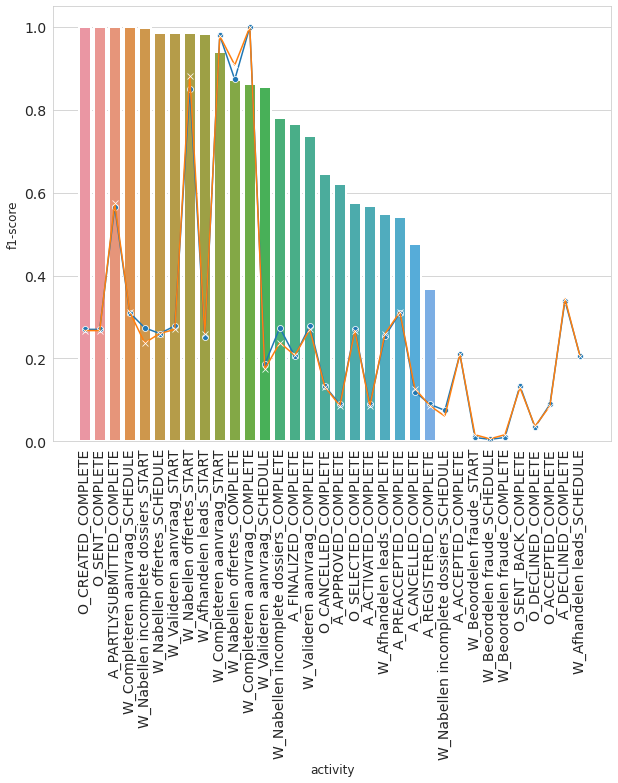

In [ ]:
import seaborn as sns # for data visualization
import matplotlib.pyplot as plt # for data visualization
%matplotlib inline
sns.set_context(rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":12, "style":"whitegrid"})  


fig, ax = plt.subplots(figsize=(10,8))
sns.set_style('whitegrid')
# Draw line plot of 

sns.barplot(data = df_merge_col, x = 'activity', y = 'f1-score', linewidth=2, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# add lineplot
sns.lineplot(data = df_merge_col, x='activity', y='counts',  marker='o')

sns.lineplot(data = df_merge_col, x='activity', y='test_sup',  marker='x')
plt.show()

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#use pca to plot the data points
def plot_2d_clusters(segment_vectors, data_Y):

    #pca = PCA(n_components=5)
    #pca_result = pca.fit_transform(segment_vectors)
    #print(data_Y)
    mds = TSNE()
    pca_result = mds.fit_transform(segment_vectors)
    x = pca_result[:, 0]
    y = pca_result[:, 1]
    #y=duration
    dataval = {}
    dataval['x']=x
    dataval['y']=y
    dataval['g']=data_Y
    #print(dataval)
    tips = pd.DataFrame.from_dict(dataval)
    return tips
    #sns.color_palette("Spectral", as_cmap=True)

tips = plot_2d_clusters(x_scaled,y_new)
#tips.head()


## Pipeline Runner

A runner function for `PPModel`. Runs multiple prediction models on various datasets for several runs. Writes the results to a dataframe and stores it on disk in the `./tmp` folder. Stores the splits, the trained models, and the results. Accepts multiple parameters.

In [ ]:
#export
from datetime import datetime
import inspect
from tqdm.notebook import tqdm

In [ ]:
#export
class Performance_Statistic():
    'Creates a results dataframe, that shows the performance of all models on all datasets on all tasks.'
    def __init__(self):
        self.df = pd.DataFrame(
        columns=['Dataset', 'Model', 'Next Step', 'Next Resource', 'Last Resource', 'Outcome',
                'Next relative Timestamp', 'Duration to Outcome', 'Activity Suffix', 'Resource Suffix'])
    def update(self,model_performance): self.df.loc[len(self.df)] = model_performance
    def to_df(self):
        return self.df

In [ ]:
#export
def _store_path(results_dir=Path('/tmp')):
    'Creates a new folder to store results'
    now = datetime.now()
    current_time = now.strftime("%Y-%m-%d_%H:%M:%S")
    results_dir=results_dir/current_time
    results_dir.mkdir()
    return results_dir

In [ ]:
#export
@delegates(PPModel)
def runner(dataset_urls,ppm_classes,store=False,runs=1,sample=False,validation_seed=None,test_seed=42,tqdm=tqdm,
           **kwargs):
    store_path= _store_path() if store else None
    '''
    Runs a number of process prediction models PPModel on a number of datasets for multiple runs.
    Stores results in ./tmp folder.
    '''
    i=0
    results=[]
    for r in tqdm(range(runs),desc='Runs'):
        performance_statistic = Performance_Statistic()
        db=tqdm(range(len(dataset_urls)),leave=False)
        for i in db:
            db.set_description(get_ds_name(dataset_urls[i]))
            ds= dataset_urls[i]
            log=import_log(ds)
            ds_name=get_ds_name(ds)
            splits=split_traces(log,ds_name,validation_seed=validation_seed,test_seed=test_seed)
            if store:
                with open(store_path/f'run{r}_{ds_name}_splits.pickle', "wb") as output_file:
                    pickle.dump(splits, output_file)
            mb=tqdm(range(len(ppm_classes)),leave=False)
            for j in mb:
                mb.set_description(ppm_classes[j].__name__.replace('PPM_',""))
                ppm_class=ppm_classes[j]
                model_path=store_path/'models'/f"run{r}" if store else None
                model=ppm_class(log,ds_name,splits,store=model_path,sample=sample,**kwargs)
                preds, actual  = model.next_step_prediction()
                predicted = torch.argmax(preds[0], dim=1)
                actual = actual[0].detach().cpu().numpy()
                predicted = predicted.detach().cpu().numpy()
                cm = confusion_matrix(actual, predicted)
                disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                disp.plot()
                plt.show()

    #return results if len(results)>1 else results[0]

This sample shows how to use the runner function:

In [ ]:

datasets=[EventLogs.Helpdesk,EventLogs.BPIC_13_CP]
ppms=[PPM_RNNwEmbedding,PPM_RNNwEmbedding]
res=runner(datasets,ppms,epoch=1,windows=partial(subsequences_fast,min_ws=0),store=True,print_output=False,
           sample=True,runs=2)


NameError: ignored

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loss-and-Metrics" data-toc-modified-id="Loss-and-Metrics-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loss and Metrics</a></span></li><li><span><a href="#Camargo" data-toc-modified-id="Camargo-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Camargo</a></span><ul class="toc-item"><li><span><a href="#Spezialized" data-toc-modified-id="Spezialized-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Spezialized</a></span></li><li><span><a href="#Concat" data-toc-modified-id="Concat-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Concat</a></span></li><li><span><a href="#Full_Concat" data-toc-modified-id="Full_Concat-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Full_Concat</a></span></li><li><span><a href="#PPMS" data-toc-modified-id="PPMS-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PPMS</a></span></li></ul></li><li><span><a href="#Evermann" data-toc-modified-id="Evermann-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Evermann</a></span><ul class="toc-item"><li><span><a href="#PPM" data-toc-modified-id="PPM-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>PPM</a></span></li></ul></li><li><span><a href="#Tax" data-toc-modified-id="Tax-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Tax</a></span><ul class="toc-item"><li><span><a href="#Spezialized" data-toc-modified-id="Spezialized-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Spezialized</a></span></li><li><span><a href="#Shared" data-toc-modified-id="Shared-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Shared</a></span></li><li><span><a href="#Mixed" data-toc-modified-id="Mixed-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Mixed</a></span></li><li><span><a href="#PPM" data-toc-modified-id="PPM-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>PPM</a></span></li></ul></li><li><span><a href="#Mida" data-toc-modified-id="Mida-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Mida</a></span><ul class="toc-item"><li><span><a href="#PPM" data-toc-modified-id="PPM-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>PPM</a></span></li></ul></li></ul></div>

In [ ]:
# default_exp baselines

Baseline implementations
===


This notebook introduces a few loss and metric functions. Afterwards, eight models based on four papers are re-implemented in `pytorch`. For each model, a `PPModel` is created.

In [ ]:
# a flag, that controls if the training process is executed
_RUN_TRAINING=True

## Loss and Metrics

This section defines some metrics and loss functions. Apart from that, we use the standart loss functions and metrics from fastai and pytorch, namely accuracy, mae, and cross_entropy

In [ ]:
#export
def maeDurDaysNormalize(p,yb,mean=0,std=0,unit=60*60*24):
    """
    Decodes time and converts from seconds to days
    Returns mae
    """
    p=p*std+mean
    yb=yb*std+mean
    return mae(p,yb)/(unit)

In [ ]:
#export
def maeDurDaysMinMax(p,yb,minn=0,maxx=0,unit=60*60*24):
    """
    Decodes time and converts from seconds to days
    Returns mae
    """

    p=p*(maxx-minn) + minn
    yb=yb*(maxx-minn) + minn
    return mae(p,yb)/(unit)

In [ ]:
#export
def _accuracy_idx(a,b,i): return accuracy(listify(a)[i],listify(b)[i])

In [ ]:
#export
class AvgMetric(Metric):
    "Average the values of `func` taking into account potential different batch sizes"
    def __init__(self, func):  self.func = func
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)
        self.total += learn.to_detach(self.func(learn.pred, *learn.yb))*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):
        return self.func.__name__ if hasattr(self.func, '__name__') else self.func.func.__name__

In [ ]:
#export
def get_metrics(o,date_col='timestamp_Relative_elapsed'):
    'A utility function that automatically selects the correct metric functions based on the PPObj o'
    number_cats=len(o.ycat_names)

    accuracies=[]
    for i in range(number_cats):
        accuracy_func=partial(_accuracy_idx,i=i)
        accuracy_func.__name__= f"acc_{o.ycat_names[i]}"
        accuracy_func=AvgMetric(accuracy_func)
        accuracies.append(accuracy_func)
    mae_days=None
    if len(o.ycont_names)>0:
        if 'minmax' in o.ycont_names[0]: # Here we expect only one timestamp
            minn,maxx = (o.procs.min_max.mins[date_col],
                         o.procs.min_max.maxs[date_col])
            mae_days=lambda p,y: maeDurDaysMinMax(listify(p)[-1],listify(y)[-1],minn=minn,maxx=maxx)
        else:
            mean,std=(o.procs.normalize.means[date_col],
                      o.procs.normalize.stds[date_col])
            mae_days=lambda p,y: maeDurDaysNormalize(listify(p)[-1],listify(y)[-1],mean=mean,std=std)
        mae_days.__name__='mae_days'
    return L(accuracies)+mae_days

In [ ]:
#export
def multi_loss_sum(o,p,y):
    '''Multi Loss function that sums up multiple loss functions. 
    The selection of the loss function is based on the PPObj o'''
    p,y=listify(p),listify(y)
    len_cat,len_cont=len(o.ycat_names),len(o.ycont_names)
    cross_entropies=[F.cross_entropy(p[i],y[i]) for i in range(len_cat)]
    maes=[mae(p[i],y[i]) for i in range(len_cat,len_cat+len_cont)]
    return torch.sum(torch.stack(list(L(cross_entropies)+L(maes))))

## Camargo

**Input**: activity, resource, duration  
**Output**: activity, resource, duration  
**Loss**: sum(cross_entropy(activity),cross_entropy(resource),mae(duration))

In [ ]:
log=import_log(EventLogs.Helpdesk)
o=PPObj(log,[Categorify,Datetify,Normalize()],date_names=['timestamp'],cat_names=['activity','resource'],
    y_names=['activity','resource','timestamp_Relative_elapsed'],splits=split_traces(log))
o
dls=o.get_dls()

In [ ]:
xcat,xcont,y=dls.one_batch()

In [ ]:
xcat.shape,xcont.shape,len(y)

(torch.Size([64, 2, 64]), torch.Size([64, 64]), 3)

### Spezialized

In [ ]:
#export
class Camargo_specialized(torch.nn.Module) :
    def __init__(self, o) :
        super().__init__()
        hidden=25
        vocab_act=len(o.procs.categorify['activity'])
        vocab_res=len(o.procs.categorify['resource'])
        emb_dim_act = int(sqrt(vocab_act))+1
        emb_dim_res = int(sqrt(vocab_res))+1

        self.emb_act = nn.Embedding(vocab_act,emb_dim_act)
        self.emb_res = nn.Embedding(vocab_res,emb_dim_res)

        self.lstm_act = nn.LSTM(emb_dim_act, hidden, batch_first=True, num_layers=2)
        self.lstm_res = nn.LSTM(emb_dim_res, hidden, batch_first=True, num_layers=2)
        self.lstm_tim = nn.LSTM(1, hidden, batch_first=True, num_layers=2)

        self.linear_act = nn.Linear(hidden, vocab_act)
        self.linear_res = nn.Linear(hidden, vocab_res)
        self.linear_tim = nn.Linear(hidden, 1)
    def forward(self, xcat,xcont):
        x_act,x_res,x_tim=xcat[:,0],xcat[:,1],xcont[:,:,None]
        x_act = self.emb_act(x_act)
        x_act,_ = self.lstm_act(x_act)
        x_act = x_act[:,-1]
        x_act = self.linear_act(x_act)
        x_act = F.softmax(x_act,dim=1)

        x_res = self.emb_res(x_res)
        x_res,_ = self.lstm_res(x_res)
        x_res = x_res[:,-1]
        x_res = self.linear_res(x_res)
        x_res = F.softmax(x_res,dim=1)

        x_tim,_ = self.lstm_tim(x_tim)
        x_tim = x_tim[:,-1]
        x_tim = self.linear_tim(x_tim)
        return x_act,x_res,x_tim

In [ ]:
m=Camargo_specialized(o)

In [ ]:
p=m(xcat,xcont)

In [ ]:
tuple(i.shape for i in p)

(torch.Size([64, 15]), torch.Size([64, 23]), torch.Size([64, 1]))

epoch,train_loss,valid_loss,acc_activity,acc_resource,mae_days,time
0,5.456880,5.373733,0.784125,0.339763,8.139686,00:31
1,5.310545,5.345272,0.784125,0.345697,7.832832,00:31


Better model found at epoch 0 with valid_loss value: 5.373732566833496.
Better model found at epoch 1 with valid_loss value: 5.345272064208984.


Better model found at epoch 0 with valid_loss value: 0.7875000238418579.


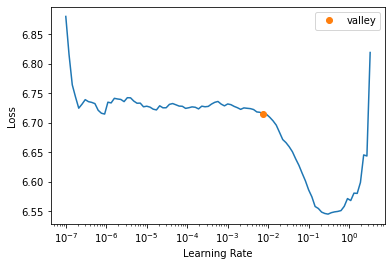

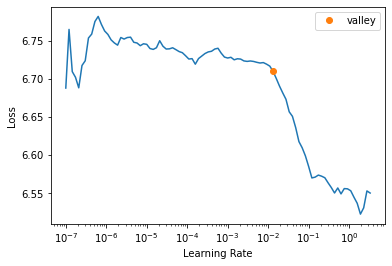

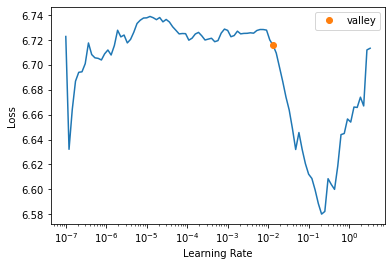

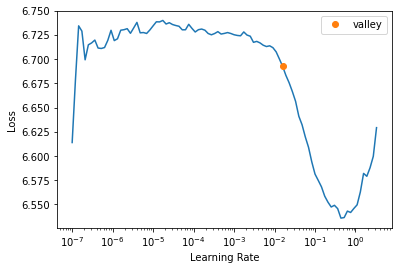

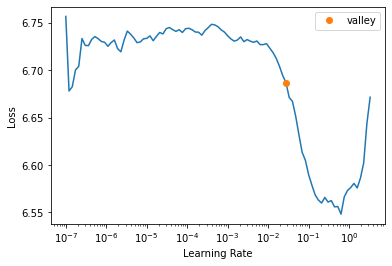

In [ ]:
_RUN_TRAINING=True
if _RUN_TRAINING:
    log=import_log(EventLogs.Helpdesk)
    o=PPObj(log,[Categorify,Datetify,Normalize],date_names=['timestamp'],cat_names=['activity','resource'],
        y_names=['activity','resource','timestamp_Relative_elapsed'],splits=split_traces(log),)
    dls=o.get_dls()
    m=Camargo_specialized(o)
    loss=0
    metrics=get_metrics(o)
    loss=partial(multi_loss_sum,o)
    preds, actual = train_validate(dls,m,loss=loss,metrics=metrics,epoch=2,print_output=True,output_index=[1,2,3])

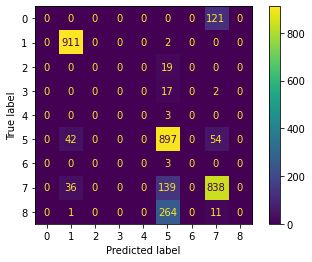

In [ ]:
#print(preds[2], actual[2])
predicted = torch.argmax(preds[0], dim=1)
actual = actual[0].detach().cpu().numpy()
predicted = predicted.detach().cpu().numpy()
cm = confusion_matrix(actual, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Concat

In [ ]:
#export
class Camargo_concat(torch.nn.Module) :
    def __init__(self, o ) :
        super().__init__()
        hidden=25
        vocab_act=len(o.procs.categorify['activity'])
        vocab_res=len(o.procs.categorify['resource'])
        emb_dim_act = int(sqrt(vocab_act))+1
        emb_dim_res = int(sqrt(vocab_res))+1

        self.emb_act = nn.Embedding(vocab_act,emb_dim_act)
        self.emb_res = nn.Embedding(vocab_res,emb_dim_res)

        self.lstm_concat= nn.LSTM(emb_dim_act+emb_dim_res, hidden, batch_first=True, num_layers=1)
        self.lstm_act = nn.LSTM(hidden, hidden, batch_first=True, num_layers=1)
        self.lstm_res = nn.LSTM(hidden, hidden, batch_first=True, num_layers=1)
        self.lstm_tim = nn.LSTM(1, hidden, batch_first=True, num_layers=2)

        self.linear_act = nn.Linear(hidden, vocab_act)
        self.linear_res = nn.Linear(hidden, vocab_res)
        self.linear_tim = nn.Linear(hidden, 1)
    def forward(self, xcat,xcont):
        x_act,x_res,x_tim=xcat[:,0],xcat[:,1],xcont[:,:,None]
        x_act = self.emb_act(x_act)

        x_res = self.emb_res(x_res)
        x_concat=torch.cat((x_act, x_res), 2)
        x_concat,_=self.lstm_concat(x_concat)

        x_act,_ = self.lstm_act(x_concat)
        x_act = x_act[:,-1]
        x_act = self.linear_act(x_act)
        x_act = F.softmax(x_act,dim=1)

        x_res,_ = self.lstm_res(x_concat)
        x_res = x_res[:,-1]
        x_res = self.linear_res(x_res)
        x_res = F.softmax(x_res,dim=1)

        x_tim,_ = self.lstm_tim(x_tim)
        x_tim = x_tim[:,-1]
        x_tim = self.linear_tim(x_tim)
        return x_act,x_res,x_tim

In [ ]:
m=Camargo_concat(o)
p=m(xcat,xcont)

In [ ]:
%%time
if _RUN_TRAINING:

    log=import_log(EventLogs.Helpdesk)
    o=PPObj(log,[Categorify,Datetify,Normalize()],date_names=['timestamp'],cat_names=['activity','resource'],
        y_names=['activity','resource','timestamp_Relative_elapsed'],splits=split_traces(log),)
    dls=o.get_dls()
    m=Camargo_concat(o)
    loss=0
    loss=partial(multi_loss_sum,o)
    train_validate(dls,m,loss=loss,metrics=get_metrics(o),epoch=1,print_output=True,output_index=[1,2,3])

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 3.81 µs


### Full_Concat 

In [ ]:
#export
class Camargo_fullconcat(torch.nn.Module) :


    def __init__(self, o  ) :
        super().__init__()

        hidden=25
        vocab_act=len(o.procs.categorify['activity'])
        vocab_res=len(o.procs.categorify['resource'])
        emb_dim_act = int(sqrt(vocab_act))+1
        emb_dim_res = int(sqrt(vocab_res))+1

        self.emb_act = nn.Embedding(vocab_act,emb_dim_act)
        self.emb_res = nn.Embedding(vocab_res,emb_dim_res)

        self.lstm_concat= nn.LSTM(emb_dim_act+emb_dim_res+1, hidden, batch_first=True, num_layers=1)
        self.lstm_act = nn.LSTM(hidden, hidden, batch_first=True, num_layers=1)
        self.lstm_res = nn.LSTM(hidden, hidden, batch_first=True, num_layers=1)
        self.lstm_tim = nn.LSTM(hidden, hidden, batch_first=True, num_layers=1)

        self.linear_act = nn.Linear(hidden, vocab_act)
        self.linear_res = nn.Linear(hidden, vocab_res)
        self.linear_tim = nn.Linear(hidden, 1)
    def forward(self, xcat,xcont):
        x_act,x_res,x_tim=xcat[:,0],xcat[:,1],xcont[:,:,None]
        x_act = self.emb_act(x_act)

        x_res = self.emb_res(x_res)
        x_concat=torch.cat((x_act, x_res,x_tim), 2)
        x_concat,_=self.lstm_concat(x_concat)

        x_act,_ = self.lstm_act(x_concat)
        x_act = x_act[:,-1]
        x_act = self.linear_act(x_act)
        x_act = F.softmax(x_act,dim=1)

        x_res,_ = self.lstm_res(x_concat)
        x_res = x_res[:,-1]
        x_res = self.linear_res(x_res)
        x_res = F.softmax(x_res,dim=1)

        x_tim,_ = self.lstm_tim(x_concat)
        x_tim = x_tim[:,-1]
        x_tim = self.linear_tim(x_tim)
        return x_act,x_res,x_tim

In [ ]:
m=Camargo_fullconcat(o)
p=m(xcat,xcont)

In [ ]:
%%time
if  _RUN_TRAINING:
    log=import_log(EventLogs.Helpdesk)
    o=PPObj(log,[Categorify,Datetify,Normalize],date_names=['timestamp'],cat_names=['activity','resource'],
        y_names=['activity','resource','timestamp_Relative_elapsed'],splits=split_traces(log),)
    dls=o.get_dls()
    m=Camargo_fullconcat(o)
    loss=0
    loss=partial(multi_loss_sum,o)
    train_validate(dls,m,loss=loss,metrics=get_metrics(o),epoch=1,print_output=True,output_index=[1,2,3])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 3.81 µs


### PPMS

In [ ]:
#export
class PPM_Camargo_Spezialized(PPModel):

    model = Camargo_specialized
    date_names=['timestamp']
    cat_names=['activity','resource']
    y_names=['activity','resource','timestamp_Relative_elapsed']
    cont_names=None
    procs=[Categorify,Datetify,Normalize,FillMissing]

    def setup(self):
        o=PPObj(self.log,self.procs,cat_names=self.cat_names,date_names=self.date_names,y_names=self.y_names,
                cont_names=self.cont_names,splits=self.splits)

        loss=partial(multi_loss_sum,o)

        # Next event prediction training
        print('Next event prediction training')
        dls=o.get_dls(bs=self.bs)
        m=self.model(o)
        self.nsp,self.nrp,self.dtnp=self._train_validate(dls,m,loss=loss,metrics=get_metrics(o),
                                                   output_index=[1,2,3])


        # Last event prediction training
        print('Last event prediction training')
        dls=o.get_dls(outcome=True,bs=self.bs)
        m=self.model(o)
        self.op,self.lrp,self.dtlp=self._train_validate(dls,m,loss=loss,metrics=get_metrics(o),
                                                 output_index=[1,2,3])



    def next_step_prediction(self): return self.nsp

    def next_resource_prediction(self):return self.nrp

    def last_resource_prediction(self): return self.lrp
    def outcome_prediction(self): return self.op
    def duration_to_next_event_prediction(self): return self.dtnp
    def duration_to_end_prediction(self): return self.dtlp
    def activity_suffix_prediction(self): pass
    def resource_suffix_prediction(self): pass

In [ ]:
#export
class PPM_Camargo_concat(PPM_Camargo_Spezialized):
    model = Camargo_concat

class PPM_Camargo_fullconcat(PPM_Camargo_Spezialized):
    model = Camargo_fullconcat

In [ ]:
%%time
if _RUN_TRAINING:
    path=EventLogs.Helpdesk
    log=import_log(path)
    ppm=PPM_Camargo_fullconcat(log,get_ds_name(path),print_output=True,epoch=1,bs=512,
                               splits=split_traces(log))
    ppm.evaluate()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.53 µs


## Evermann

**Input**:  activity or resource  
**Output**: activity or resource  
**Loss**: cross_entropy(activity) or cross_entropy(resource)

In [ ]:
#export

class Evermann(torch.nn.Module) :
    def __init__(self, o) :
        super().__init__()
        vocab_size=len(o.procs.categorify[o.y_names[0]])
        hidden_dim=125
        emb_dim = 5


        self.embeddings = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True, num_layers=2)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embeddings(x.squeeze())
        x = self.dropout(x)
        x, _ = self.lstm(x)
        x = self.linear(x[:,-1])
        return F.softmax(x,dim=1)

In [ ]:
col='activity'
o=PPObj(log,procs=[Categorify],cat_names=col,y_names=col,splits=split_traces(log))
dls=o.get_dls()
xb,yb=dls.one_batch()

In [ ]:
xb.shape,yb.shape

(torch.Size([64, 64]), torch.Size([64]))

In [ ]:
m=Evermann(o)

In [ ]:
pb=m(xb)
F.cross_entropy(pb,yb),accuracy(pb,yb)

(tensor(2.7095, grad_fn=<NllLossBackward>), TensorBase(0.0469))

In [ ]:
partial(multi_loss_sum,o)(pb,yb)

tensor(2.7095, grad_fn=<SumBackward0>)

In [ ]:
loss=partial(multi_loss_sum,o)
metrics=get_metrics(o)

In [ ]:
%%time
if _RUN_TRAINING:
    train_validate(dls,m,loss=loss,metrics=metrics,epoch=1)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.05 µs


### PPM

In [ ]:
#export
class PPM_Evermann(PPM_RNNwEmbedding): 
    model = Evermann

In [ ]:
%%time
if _RUN_TRAINING:
    runner([EventLogs.Helpdesk,EventLogs.Mobis],[PPM_Evermann,PPM_RNNwEmbedding],
           bs=1024,epoch=1,print_output=False)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 3.81 µs


## Tax

**Input**:  activity or duration  
**Output**: activity or duration  
**Loss**: cross_entropy(activity) or mae(duration) in days

### Spezialized

In [ ]:
#export
class Tax_et_al_spezialized(torch.nn.Module) :
    def __init__(self,o) :
        super().__init__()
        vocab_size=len(o.procs.categorify[o.y_names[0]])
        hidden_dim=125
        self.lstm_act = nn.LSTM(vocab_size, hidden_dim, batch_first=True, num_layers=2)
        self.lstm_tim = nn.LSTM(3, hidden_dim, batch_first=True, num_layers=2)

        self.linear_act = nn.Linear(hidden_dim, vocab_size)
        self.linear_tim = nn.Linear(hidden_dim, 1)


    def forward(self, xcat,xcont):
        x_act,x_tim = xcat.permute(0,2,1),xcont.squeeze().permute(0,2,1)
        x_act, _ = self.lstm_act(x_act.float())
        x_act=self.linear_act(x_act[:,-1])
        x_act=F.softmax(x_act,dim=1)
        x_tim, _ = self.lstm_tim(x_tim)
        x_tim=self.linear_tim(x_tim[:,-1])
        return x_act,x_tim

In [ ]:
log=import_log(EventLogs.BPIC_12)

In [ ]:
datetify=Datetify(date_encodings=['secSinceSunNoon','secSinceNoon','Relative_elapsed'])
o=PPObj(log,[Categorify,OneHot,datetify,Normalize],cat_names='activity',splits=split_traces(log),
        date_names='timestamp',y_names=['activity','timestamp_Relative_elapsed'])
dls=o.get_dls()

In [ ]:
xcat,xcont,yb=(dls.one_batch())

In [ ]:
o.cont_names

(#3) ['timestamp_secSinceSunNoon','timestamp_secSinceNoon','timestamp_Relative_elapsed']

In [ ]:
m=Tax_et_al_spezialized(o)

In [ ]:
p=m(xcat,xcont)

In [ ]:
loss=partial(multi_loss_sum,o)
loss(p,yb)

TensorBase(4.4224, grad_fn=<AliasBackward>)

In [ ]:
metrics=get_metrics(o)


In [ ]:
if _RUN_TRAINING:
    datetify=Datetify(date_encodings=['secSinceSunNoon','secSinceNoon','Relative_elapsed'])
    o=PPObj(log,[Categorify,OneHot,datetify,Normalize],cat_names='activity',splits=split_traces(log),
            date_names='timestamp',y_names=['activity','timestamp_Relative_elapsed'])
    dls=o.get_dls()
    m=Tax_et_al_spezialized(o)
    loss=partial(multi_loss_sum,o)
    metrics=get_metrics(o)
    train_validate(dls,m,loss=loss,metrics=metrics,epoch=1,output_index=[1,2])

### Shared

In [ ]:
#export
class Tax_et_al_shared(torch.nn.Module) :
    def __init__(self,o) :
        super().__init__()
        vocab_size=len(o.procs.categorify[o.y_names[0]])
        hidden_dim=125
        self.lstm = nn.LSTM(vocab_size+3, hidden_dim, batch_first=True, num_layers=2)

        self.linear_act = nn.Linear(hidden_dim, vocab_size)
        self.linear_tim = nn.Linear(hidden_dim, 1)


    def forward(self,xcat,xcont):
        x_act,x_tim = xcat.permute(0,2,1),xcont.squeeze().permute(0,2,1)

        x_concat=torch.cat((x_act.float(), x_tim), 2)
        x_concat, _ = self.lstm(x_concat)

        x_act=self.linear_act(x_concat[:,-1])
        x_act=F.softmax(x_act,dim=1)

        x_tim=self.linear_tim(x_concat[:,-1])
        return x_act,x_tim

In [ ]:
m=Tax_et_al_shared(o)

In [ ]:
p=m(xcat,xcont)

In [ ]:
loss(p,yb)

TensorBase(4.3842, grad_fn=<AliasBackward>)

In [ ]:
if _RUN_TRAINING:
    datetify=Datetify(date_encodings=['secSinceSunNoon','secSinceNoon','Relative_elapsed'])
    o=PPObj(log,[Categorify,OneHot,datetify,Normalize],cat_names='activity',splits=split_traces(log),
            date_names='timestamp',y_names=['activity','timestamp_Relative_elapsed'])
    m=Tax_et_al_shared(o)
    dls=o.get_dls()
    loss=partial(multi_loss_sum,o)
    metrics=get_metrics(o)
    train_validate(dls,m,loss=loss,metrics=metrics,epoch=1,output_index=[1,2])

### Mixed

In [ ]:
#export
class Tax_et_al_mixed(torch.nn.Module) :
    def __init__(self,o,numlayers_shared=3,numlayers_single=3) :
        super().__init__()
        vocab_size=len(o.procs.categorify[o.y_names[0]])
        hidden_dim=125

        self.lstm_act = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=numlayers_single)
        self.lstm_tim = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=numlayers_single)
        self.lstm = nn.LSTM(vocab_size+3, hidden_dim, batch_first=True, num_layers=numlayers_shared)

        self.linear_act = nn.Linear(hidden_dim, vocab_size)
        self.linear_tim = nn.Linear(hidden_dim, 1)


    def forward(self,xcat,xcont):
        x_act,x_tim = xcat.permute(0,2,1),xcont.squeeze().permute(0,2,1)


        x_concat=torch.cat((x_act.float(), x_tim), 2)
        x_concat, _ = self.lstm(x_concat)

        x_act, _ = self.lstm_act(x_concat)
        x_act=self.linear_act(x_act[:,-1])
        x_act=F.softmax(x_act,dim=1)

        x_tim, _ = self.lstm_tim(x_concat)
        x_tim=self.linear_tim(x_tim[:,-1])
        return x_act,x_tim

In [ ]:
m=Tax_et_al_mixed(o)

In [ ]:
xcat,xcont,yb=dls.one_batch()

In [ ]:
p=m(xcat,xcont)

In [ ]:
loss(p,yb)

TensorBase(4.6303, grad_fn=<AliasBackward>)

In [ ]:
log=import_log(EventLogs.BPIC_12)
traces=split_traces(log)[0][:100]
splits=traces[:60],traces[60:80],traces[80:100]
splits=split_traces(log)

In [ ]:
if _RUN_TRAINING:
    datetify=Datetify(date_encodings=['secSinceSunNoon','secSinceNoon','Relative_elapsed'])
    o=PPObj(log,[Categorify,OneHot,datetify,Normalize],cat_names='activity',splits=splits,
            date_names='timestamp',y_names=['activity','timestamp_Relative_elapsed'])
    m=Tax_et_al_mixed(o)  
    dls=o.get_dls()
    loss=partial(multi_loss_sum,o)
    metrics=get_metrics(o)
    train_validate(dls,m,loss=loss,metrics=metrics,epoch=1,output_index=[1,2],lr_find=False)

### PPM

In [ ]:
#export
class PPM_Tax_Spezialized(PPModel):

    model = Tax_et_al_spezialized
    date_names=['timestamp']
    cat_names=['activity']
    y_names=['activity','timestamp_Relative_elapsed']
    cont_names=None
    procs=[Categorify,OneHot,Datetify(date_encodings=['secSinceSunNoon','secSinceNoon','Relative_elapsed']),
           Normalize,FillMissing]

    def setup(self):
        o=PPObj(self.log,self.procs,cat_names=self.cat_names,date_names=self.date_names,y_names=self.y_names,
                cont_names=self.cont_names,splits=self.splits)

        loss=partial(multi_loss_sum,o)

        # Next event prediction training
        print('Next event prediction training')
        dls=o.get_dls(bs=self.bs)
        m=self.model(o)
        self.nsp,self.dtnp=self._train_validate(dls,m,loss=loss,metrics=get_metrics(o),
                                                   output_index=[1,2])


        # Last event prediction training
        print('Last event prediction training')
        dls=o.get_dls(outcome=True,bs=self.bs)
        m=self.model(o)
        self.op,self.dtlp=self._train_validate(dls,m,loss=loss,metrics=get_metrics(o),
                                                 output_index=[1,2])



    def next_step_prediction(self): return self.nsp


    def outcome_prediction(self): return self.op
    def duration_to_next_event_prediction(self): return self.dtnp
    def duration_to_end_prediction(self): return self.dtlp
    def activity_suffix_prediction(self): pass
    def resource_suffix_prediction(self): pass

In [ ]:
#export
class PPM_Tax_Shared(PPM_Tax_Spezialized):
    model = Tax_et_al_shared

class PPM_Tax_Mixed(PPM_Tax_Spezialized):
    model = Tax_et_al_mixed

In [ ]:
%%time
if _RUN_TRAINING:
    log=import_log(path)
    ppm=PPM_Tax_Mixed(log,get_ds_name(path),sample=True,print_output=True,epoch=1,bs=512,splits=split_traces(log))
    ppm.evaluate()

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs


## Mida

**Input**: multi categorical atts and multi cont atts  
**Output**: activity or resource or duration  
**Loss**: cross_entropy(activity) or cross_entropy(resource) or mae(duration) in days

In [ ]:
#export
class MiDA(Module):
    def __init__(self,o,seq_len=64) :
        super().__init__()
        hidden_dim1=100
        hidden_dim2=100

        out=o.y_names[0]
        emb_szs=[(len(o.procs.categorify[c]),len(o.procs.categorify[c])//2 ) for c in o.cat_names ]
        self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
        self.n_cont=len(o.cont_names)
        self.n_emb = sum(e.embedding_dim for e in self.embeds)
        self.lstm1=nn.LSTM(self.n_cont+self.n_emb, hidden_dim1, batch_first=True, num_layers=1)

        self.bn_cont = nn.BatchNorm1d(self.n_cont)
        self.lstm2=nn.LSTM(hidden_dim1, hidden_dim2, batch_first=True, num_layers=1)
        #self.bn2=nn.BatchNorm1d(seq_len)
        #self.bn1=nn.BatchNorm1d(seq_len)

        if out in  o.procs.categorify.classes:
            self.lin=nn.Linear(hidden_dim2,len(o.procs.categorify[out]))
            self.is_classifier=True
        else:
            self.lin=nn.Linear(hidden_dim2,1)
            self.is_classifier=False


    def forward(self, x_cat,x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 2)
        if self.n_cont != 0:
            if self.n_cont == 1: x_cont=x_cont[:,None]
            if self.bn_cont: x_cont=self.bn_cont(x_cont).transpose(2,1)
            x = torch.cat([x, x_cont], 2) if self.n_emb != 0 else x_cont

        x,_=self.lstm1(x)
        #x= self.bn1(x)
        x,h=self.lstm2(x)
        #x=self.bn2(x[:,-1])
        x=self.lin(x[:,-1])
        if self.is_classifier: x=F.softmax(x,1)
        return x

In [ ]:
log=import_log(EventLogs.Helpdesk)

In [ ]:
o=PPObj(log,[Categorify,Normalize,Datetify,FillMissing],
        cat_names=['activity','resource'],date_names=['timestamp'],y_names='activity',splits=split_traces(log))
dls=o.get_dls()

In [ ]:
xcat,xcont,yb=dls.one_batch()

In [ ]:
m=MiDA(o)

In [ ]:
p=m(xcat,xcont)

In [ ]:
%%time
if  _RUN_TRAINING:
    log=import_log(EventLogs.BPIC_12)
    o=PPObj(log,[Categorify,Normalize,Datetify,FillMissing],
            cat_names=['activity','resource'],date_names=['timestamp'],
            splits=split_traces(log))
    o.set_y_names('timestamp_Relative_elapsed')
    dls=o.get_dls(bs=512)
    seq_len=o.items.event_id.max()
    m=MiDA(o,seq_len)
    loss=partial(multi_loss_sum,o)
    metrics=get_metrics(o)
    train_validate(dls,m,epoch=5,loss=loss,metrics=metrics,print_output=True)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.29 µs


### PPM

In [ ]:
subsequences_fast??

In [ ]:
#export

class PPM_MiDA(PPModel):
    model = MiDA

    procs=[Categorify,Normalize,Datetify,FillMissing]

    def _attr_from_dict(self,ds_name):
        if not self.attr_dict: raise AttributeError('attr_dict is required!')

        return (listify(self.attr_dict[self.ds_name]['cat attr']),
                listify(self.attr_dict[self.ds_name]['num attr']),
                listify(self.attr_dict[self.ds_name]['date attr']))

    def setup(self):
        cat_names,cont_names,date_names=self._attr_from_dict(self.ds_name)
        self.o=PPObj(self.log,[Categorify,Normalize,Datetify,FillMissing],
                     cat_names=cat_names,date_names=date_names,cont_names=cont_names,
                     splits=self.splits)





    def next_step_prediction(self,col='activity',outcome=False):
        seq_len=(self.o.items.event_id.max()) # seq_len = max trace len, Todo make it nicer
        self.o.set_y_names(col)
        print(self.o.y_names)
        dls=self.o.get_dls(bs=self.bs,outcome=outcome)
        m=self.model(self.o,seq_len)
        loss=partial(multi_loss_sum,self.o)
        metrics=get_metrics(self.o)
        return self._train_validate(dls,m,loss=loss,metrics=metrics)

    def next_resource_prediction(self):return self.next_step_prediction(outcome=False,col='resource')

    def last_resource_prediction(self): return self.next_step_prediction(outcome=True,col='resource')
    def outcome_prediction(self): return self.next_step_prediction(outcome=True,col='activity')

    def duration_to_next_event_prediction(self):
        return self.next_step_prediction(outcome=False,col='timestamp_Relative_elapsed')

    def duration_to_end_prediction(self):
        return self.next_step_prediction(outcome=True,col='timestamp_Relative_elapsed')

In [ ]:
#export
def create_attr_dict(attr_list):
    attr_df=pd.DataFrame(attr_list,columns=['name','cat attr','num attr','date attr'])
    attr_df.index=attr_df.name
    attr_df.drop('name',axis=1,inplace=True)
    attr_df.index.name=""
    attr_dict=attr_df.apply(lambda x:(x.str.split(', '))).T.to_dict()
    return attr_dict

In [ ]:
#export

attr_list=[
    ['BPIC12','activity, resource','AMOUNT_REQ','timestamp'],
    ['BPIC12_W','activity, resource','AMOUNT_REQ','timestamp'],
    ['BPIC12_Wc','activity, resource','AMOUNT_REQ','timestamp'],
    ['BPIC12_O','activity, resource','AMOUNT_REQ','timestamp'],
    ['BPIC12_A','activity, resource','AMOUNT_REQ','timestamp'],
    ['Mobis','activity, resource, type','cost','timestamp'],
    ['BPIC13_CP','activity, resource, resource country, organization country, organization involved, impact, product, org:role',
     None,'timestamp'],
    ['Helpdesk','activity, resource',None,'timestamp'],
    ['BPIC17_O','activity, Action, NumberOfTerms, resource',
     'FirstWithdrawalAmount, MonthlyCost, OfferedAmount, CreditScore', 'timestamp'],
    ['BPIC20_RFP','org:role, activity, resource, Project, Task, OrganizationalEntity',
     'RequestedAmount','timestamp']
]


attr_dict=create_attr_dict(attr_list)

In [ ]:
%%time
if _RUN_TRAINING:
    path=EventLogs.Helpdesk
    log=import_log(path)
    ppm=PPM_MiDA(log,get_ds_name(path),print_output=True,epoch=1,bs=512,attr_dict=attr_dict,splits=split_traces(log))
    ppm.setup()
    ppm.next_step_prediction()

['activity']


epoch,train_loss,valid_loss,acc_activity,time
0,2.552496,2.540823,0.275680,00:01


Better model found at epoch 0 with valid_loss value: 2.540823221206665.


Better model found at epoch 0 with valid_loss value: 0.27172619104385376.
CPU times: user 12.3 s, sys: 14 s, total: 26.3 s
Wall time: 28 s


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Models" data-toc-modified-id="Models-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Models</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#PPM" data-toc-modified-id="PPM-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>PPM</a></span></li></ul></div>

In [ ]:
# default_exp mppn

MPPN
===



This notebook includes the implementation of the `MPPN` as described in the paper. It includes the pytorch models, a training procedure containing pre-processing and data loader generation, the implementation of the `PPModel` based on MPPN's pytorch models for each process prediction task.

In [ ]:
#hide

%load_ext autoreload
%autoreload 2
%load_ext memory_profiler
%load_ext line_profiler
%matplotlib inline

In [ ]:
_RUN_TRAINING=True

## Models

In [ ]:
#export

class BaseMPPN(nn.Module):

    def __init__(self, num_perspectives, feature_size=64, output_dim=128):
        super(BaseMPPN, self).__init__()
        self.feature_size = feature_size
        self.output_dim = output_dim
        self.mode = 99
        self.stop_training = False

        if self.mode == 1:
            self.num_perspectives = 1
        else:
            self.num_perspectives = num_perspectives

        self.CNN = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.Conv2d(64, 64, kernel_size=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=64, out_channels=self.feature_size, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.MLP = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(self.num_perspectives * self.feature_size, self.num_perspectives * self.feature_size),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(self.num_perspectives * self.feature_size, self.num_perspectives * int(self.feature_size)),
            nn.ReLU(inplace=True),
            nn.Linear(self.num_perspectives * int(self.feature_size), self.output_dim),
        )

    def forward(self, x):
        x = x.transpose(0, 1)

        view_pool = []

        for v in x:
            """size of v: [batch_size, 3, img_height, img_width]"""
            """Get features from GAFs using CNN"""
            v = self.CNN(v)
            """size of v: [batch_size, feature_size, ?, ?], last two should be 1, 1"""
            """Reduce dimensions from 4 to 2 (first is batchsize)"""
            v = v.view(v.size(0), self.feature_size)


            view_pool.append(v)


        pooled_view = view_pool[0]
        """Max-pooling of all views"""
        if self.mode == 1:
            for i in range(1, len(view_pool)):
                pooled_view = torch.max(pooled_view, view_pool[i])

        else:
            """Concatenate features from all perspectives"""
            pooled_view = torch.cat(view_pool, dim=1)

        """Get representation from MLP"""
        representation = self.MLP(pooled_view)

        return representation

    def count_parameters(self):

        param_CNN = sum(p.numel() for p in self.MLP.parameters() if p.requires_grad)
        param_MLP = sum(p.numel() for p in self.MLP.parameters() if p.requires_grad)

        params = param_CNN + param_MLP

        return params

NameError: ignored

In [ ]:
#export

class MPPNClassifier(BaseMPPN):
    """
    Extends Base MPPN with one classification layer.
    """

    def __init__(self, num_perspectives, num_classes, feature_size=64, output_dim=128,with_softmax=True):
        super().__init__(num_perspectives, feature_size=feature_size, output_dim=output_dim)
        self.with_softmax=num_classes!=1
        self.classification = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(output_dim, num_classes)
        )

    def forward(self, x):
        representation = BaseMPPN.forward(self, x)
        classifier_output = self.classification(representation)
        if self.with_softmax:
            classifier_output=F.log_softmax(classifier_output,dim=1)
        return classifier_output

In [ ]:
#export

class MPPNMultitask(BaseMPPN):
    """
    Extends the MPPNClassifier with multiple heads to predict multiple outputs at once.
    """
    def __init__(self, num_perspectives, output_attr, feature_size=64, representation_dim=128):
        super().__init__(num_perspectives, feature_size=feature_size, output_dim=representation_dim)
        del self.MLP

        self.output_attr = output_attr
        self.representation_dim = representation_dim

        """Get the output dimension of the CNN"""
        self.CNN_out_dim = self.CNN[-3].out_channels

        self.MLP = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(self.num_perspectives * self.feature_size, self.num_perspectives * int(self.feature_size/2)),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(self.num_perspectives * int(self.feature_size/2), self.representation_dim),
        )

        """Dynamically create heads for each attribute to predict"""
        self.output_attr = self.output_attr
        self.heads = nn.ModuleList()
        for attr_name, output_dim in self.output_attr.items():
            #print("Head", attr_name)
            self.heads.append(self.create_head(output_dim))


    def forward(self, x):

        x = x.transpose(0, 1)

        view_pool = []

        for v in x:
            """size of v: [batch_size, 3, img_height, img_width]"""
            """Get features from GAFs using CNN"""
            v = self.CNN(v)
            """size of v: [batch_size, feature_size, ?, ?], last two should be 1, 1"""
            """Reduce dimensions from 4 to 2 (first is batchsize)"""
            v = v.view(v.size(0), self.feature_size)

            view_pool.append(v)

        pooled_view = view_pool[0]
        """Max-pooling of all views"""
        if self.mode == 1:
            for i in range(1, len(view_pool)):
                pooled_view = torch.max(pooled_view, view_pool[i])

        else:
            """Concatenate features from all perspectives"""
            pooled_view = torch.cat(view_pool, dim=1)

        shared = self.MLP(pooled_view)

        outputs = []

        """Predict each attribute"""
        for head in self.heads:
            if head[-1].out_features > 1:
                outputs.append(F.log_softmax(head(shared), dim=1))
            else:
                outputs.append(head(shared))

        return outputs


    def create_head(self, num_classes):
        """Create a head, i.e. a subnetwork to predict a certain attribute in multi-task fashion"""
        head = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(self.representation_dim, self.representation_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.representation_dim, num_classes)
        )

        return head

    def count_parameters(self):

        param_CNN = sum(p.numel() for p in self.MLP.parameters() if p.requires_grad)
        param_MLP = sum(p.numel() for p in self.MLP.parameters() if p.requires_grad)
        param_heads = sum(p.numel() for head in self.heads for p in head.parameters() if p.requires_grad)

        params = param_CNN + param_MLP + param_heads

        return params

In [ ]:
#export

def load_checkpoint(path, filename):
    """
    Load checkpoint from disk

    Parameters
    ----------
    path
    filename

    Returns
    -------

    """
    loadpath = os.path.join(path, filename + '_checkpoint.pth.tar')

    assert os.path.isfile(loadpath), 'Error: no checkpoint file found!'

    checkpoint = torch.load(loadpath)

    return checkpoint

In [ ]:
#export

import torch.utils.model_zoo as model_zoo
model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

def mppn_pretraining_model(pretrained=False, **kwargs):
    """Returns a model either pretrained as alexnet or on GAF images."""
    model = MPPNClassifier(**kwargs)

    pretrained_model = "alexnet"

    if pretrained:
        if pretrained_model == "alexnet":
            print("Loading Alexnet to train MPPNs CNN from scratch")
            pretrained_dict = model_zoo.load_url(model_urls['alexnet'])
            model_dict = model.state_dict()
            # 1. filter out unnecessary keys
            pretrained_dict = {k: v for k, v in pretrained_dict.items() if
                               k in model_dict and v.shape == model_dict[k].shape}
            # 2. overwrite entries in the existing state dict
            model_dict.update(pretrained_dict)
            # 3. load the new state dict
            model.load_state_dict(model_dict)

        elif pretrained_model == "MPPN_GAF":
            print("Load pretrained MPPN trained with GAFs on variant classification")
            checkpoint = load_checkpoint(os.path.join(root_dir(), "data", "ML", "checkpoint"),
                                         filename="MPPN_gaf_pretrained")
            best_model = checkpoint["model"]
            best_model.load_state_dict(checkpoint['state_dict'])

            model.CNN = best_model.CNN

    return model

In [ ]:
#export

def mppn_representation_learning_model(pretrained, num_perspectives, output_attr, feature_size=64, representation_dim=128):
    """Returns a model for representation learning (multitask). CNN is pretrained on GAF images"""
    model = MPPNMultitask(num_perspectives, output_attr, feature_size, representation_dim)

    if pretrained:
        print("Load pretrained MPPN trained with GAFs on variant classification")
        #checkpoint = load previously trained model on GAF images
        best_model = checkpoint["model"]
        best_model.load_state_dict(checkpoint['state_dict'])

        model.CNN = best_model.CNN
    else:
        alexnet_mppn = mppn_pretraining_model(pretrained=True, num_perspectives=num_perspectives, num_classes=1)
        model.CNN = alexnet_mppn.CNN

    return model

In [ ]:
#export

def mppn_fine_tuning_model(representation_model, num_perspectives, num_classes):
    """
    Fine-tune a MPPN model that has been trained as representation model on a specific task

    Parameters
    ----------
    dataset: Specifies the dataset, for which the model was trained before.

    Returns
    -------
    """


    model = MPPNClassifier(num_perspectives, num_classes=num_classes)

    model.CNN = representation_model.CNN
    model.MLP = representation_model.MLP


    return model

## Training

In [ ]:
#export

from pyts.image import GramianAngularField
from PIL import Image

def _gaf_loop(e,transformer):
        inp,y=e
        inp[inp>1]=1
        inp[inp<0]=0
        inp=inp*2-1
        x=torch.stack(
            tuple(_gaf_attr(inp[:,i],transformer) for i in range(inp.shape[1]))
        ).transpose(0,1)
        x=x[:,:,None].expand(-1,-1,3,-1,-1)
        return x,y

def _gaf_attr(x,transformer):
    try:

        x = transformer.transform(x)
    except ValueError as e:
        print(x)
        raise e
    x=tensor(x).cuda()
    x = x * 255
    return x



class gaf_transform(ItemTransform):
    ''' GAF transormation: converts a bash into a gramian angular field and reshapes it to RGB'''
    def __init__(self,gs=64):
        self.transformer=GramianAngularField(image_size=gs,sample_range=None, method="s", overlapping=True)

    def encodes(self,e): return _gaf_loop(e,self.transformer)

In [ ]:
v=torch.rand((2556,10,100)),10
gt=gaf_transform()

In [ ]:
%%time
x,y=gt(v)


CPU times: user 5.55 s, sys: 1.22 s, total: 6.78 s
Wall time: 3.71 s


In [ ]:
#export
def mppn_get_output_attributes(o):
    '''Utility function that puts vocab size of each output attribute in a dict. 
    For regression tasks, it adds vocab size 1'''
    output_attributes = {i:len(o.procs.categorify[i]) for i in o.ycat_names }
    for i in o.ycont_names: output_attributes[i]=1
    return output_attributes

The next few cells show how to create a dataloader for MPPN and apply them to the representation learning and the finetuning step

In [ ]:
# Create mppn repreentation learning and create the dataloader
path=EventLogs.Mobis
log=import_log(path)
_t=attr_dict[get_ds_name(path)]
cat_names,cont_names,date_names=[_t[i] for i in list(_t)]
o=PPObj(log,[Categorify,Datetify,FillMissing,MinMax],
        cat_names=cat_names,cont_names=cont_names,date_names=date_names,
        splits=split_traces(log),y_names=['activity','resource','timestamp_Relative_elapsed_minmax'])
output_attributes=mppn_get_output_attributes(o)
m = mppn_representation_learning_model(False, len(o.cont_names), output_attributes)
dls=o.get_dls(after_batch=gaf_transform,bs=64)


Loading Alexnet to train MPPNs CNN from scratch


In [ ]:
# Get one batch
xb,yb=dls.one_batch()

In [ ]:
# Get loss and metrics
loss=partial(multi_loss_sum,o)
metrics=get_metrics(o)


In [ ]:
# Test forward pass
xb=xb.cpu()
p=m(xb)
loss(p,yb)

TensorBase(10.9851, grad_fn=<AliasBackward>)

epoch,train_loss,valid_loss,acc_activity,acc_resource,mae_days,time
0,2.806212,2.718509,0.939918,0.402286,6.824545,00:57


Better model found at epoch 0 with valid_loss value: 2.7185089588165283.


Better model found at epoch 0 with valid_loss value: 0.940420389175415.


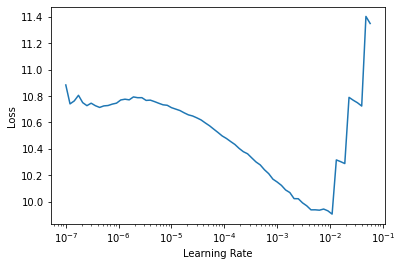

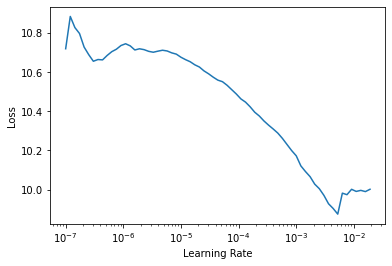

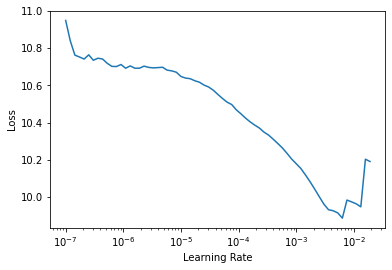

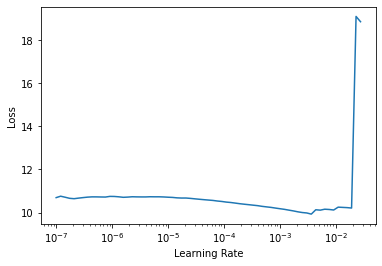

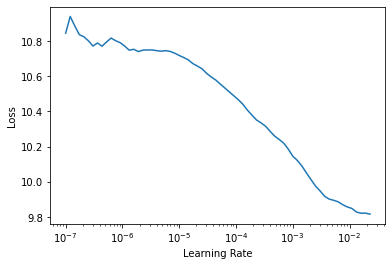

In [ ]:
# Train representation learning model
if _RUN_TRAINING:
    train_validate(dls,m,loss=loss,metrics=metrics,epoch=1)

In [ ]:
# Create Fine-tuning model
col='activity'
m2 = mppn_fine_tuning_model(m, len(output_attributes), output_attributes[col])

In [ ]:
# Change input and output features for the dataloader
o.ycat_names=L(col)
o.ycont_names=L()

In [ ]:
# get new dataloader for next-activity prediction
dls=o.get_dls(after_batch=gaf_transform,bs=60)

In [ ]:
# get new loss and metrics for for next-activity prediction
loss=partial(multi_loss_sum,o)
metrics=get_metrics(o)

In [ ]:
# Test forward pass

xb,yb=dls.one_batch()
yb.shape

p=m2.cuda()(xb.cuda())

accuracy(p.cuda(),yb.cuda())

TensorBase(0., device='cuda:0')

epoch,train_loss,valid_loss,acc_activity,time
0,0.201164,0.185873,0.936980,00:58
1,0.164601,0.175458,0.930531,00:53
2,0.193403,0.174247,0.940000,00:54
3,0.187607,0.199790,0.936327,00:54
4,0.203035,0.222902,0.927510,00:54


Better model found at epoch 0 with valid_loss value: 0.18587279319763184.
Better model found at epoch 1 with valid_loss value: 0.17545795440673828.
Better model found at epoch 2 with valid_loss value: 0.17424732446670532.
No improvement since epoch 1: early stopping


Better model found at epoch 0 with valid_loss value: 0.939941942691803.


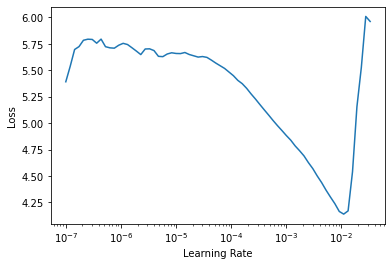

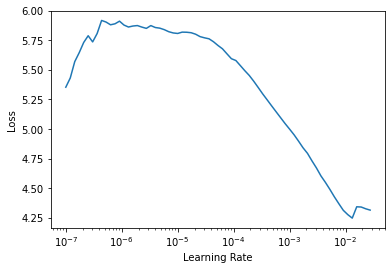

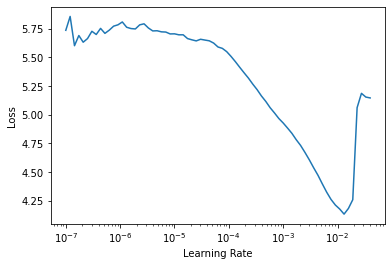

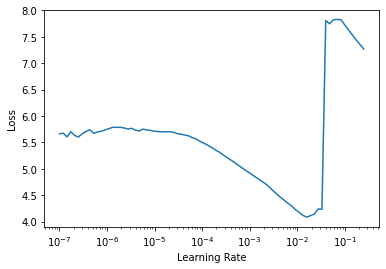

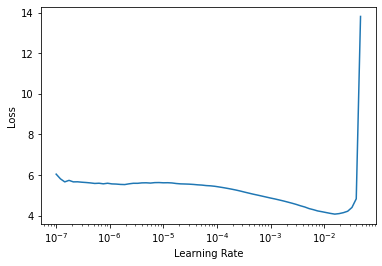

In [ ]:
# Train model
if _RUN_TRAINING:
    train_validate(dls,m2,loss=loss,metrics=metrics,epoch=1)

## PPM

Creates the PPM for the MPPM. In the setup der general representation learning model is trained. Afterwards, in each prediction task, a seperate head is created, which is than fine-tuned for the specific task.

In [ ]:
#export
import copy

In [ ]:
#export

class PPM_MPPN(PPModel):


    def _attr_from_dict(self,ds_name):
        if not self.attr_dict: raise AttributeError('attr_dict is required!')

        return (listify(self.attr_dict[self.ds_name]['cat attr']),
                listify(self.attr_dict[self.ds_name]['num attr']),
                listify(self.attr_dict[self.ds_name]['date attr']))


    def setup(self):
        def act_acc(p,y): return accuracy(p[0],y[0])
        def act_res(p,y): return accuracy(p[1],y[1])
        cat_names,cont_names,date_names=self._attr_from_dict(self.ds_name)
        self.o=PPObj(self.log,[Categorify,Datetify,FillMissing,MinMax],
                     cat_names=cat_names,date_names=date_names,cont_names=cont_names,
                     y_names=['activity','resource','timestamp_Relative_elapsed'],
                     splits=self.splits)
        self.o.cont_names=['timestamp_Relative_elapsed']
        norm=Normalize()
        self.o.procs.add(norm,self.o)
        self.mean=norm.means['timestamp_Relative_elapsed']
        self.std=norm.stds['timestamp_Relative_elapsed']
        self.o.cont_names=L(['activity_minmax','resource_minmax','timestamp_Relative_elapsed_minmax'])
        self.output_attributes=mppn_get_output_attributes(self.o)
        self.pretrain = mppn_representation_learning_model(False, len(self.o.cont_names), self.output_attributes)
        dls=self.o.get_dls(after_batch=gaf_transform,bs=self.bs)
        loss=partial(multi_loss_sum,self.o)
        time_metric=lambda p,y: maeDurDaysNormalize(listify(p)[-1],listify(y)[-1],mean=self.mean,std=self.std)
        self._train_validate(dls,self.pretrain,loss=loss,metrics=[act_acc,act_res,time_metric])




    def next_step_prediction(self,col='activity',outcome=False):
        pretrain=copy.deepcopy(self.pretrain)
        m = mppn_fine_tuning_model(pretrain, len(self.output_attributes), self.output_attributes[col])
        self.o.ycat_names,self.o.ycont_names=L(col),L()
        dls=self.o.get_dls(after_batch=gaf_transform,bs=self.bs,outcome=outcome)
        loss=partial(multi_loss_sum,self.o)
        metrics=get_metrics(self.o)
        return self._train_validate(dls,m,loss=loss,metrics=metrics)

    def next_resource_prediction(self):return self.next_step_prediction(outcome=False,col='resource')

    def last_resource_prediction(self): return self.next_step_prediction(outcome=True,col='resource')
    def outcome_prediction(self): return self.next_step_prediction(outcome=True)

    def duration_to_next_event_prediction(self,outcome=False,col='timestamp_Relative_elapsed'):
        pretrain=copy.deepcopy(self.pretrain)
        time=partial(maeDurDaysNormalize,mean=self.mean,std=self.std)
        m = mppn_fine_tuning_model(pretrain, len(self.output_attributes), self.output_attributes[col])
        self.o.ycat_names,self.o.ycont_names=L(),L(col)
        dls=self.o.get_dls(after_batch=gaf_transform,bs=self.bs,outcome=outcome)
        xb,yb=dls.one_batch()
        return self._train_validate(dls,m,loss=mae,metrics=time)


    def duration_to_end_prediction(self):return self.duration_to_next_event_prediction(outcome=True)

In [ ]:
%%time
if  _RUN_TRAINING:
    path=EventLogs.BPIC_12_O
    log=import_log(path)
    ppm=PPM_MPPN(log,get_ds_name(path),split_traces(log),print_output=True,epoch=1,bs=512,attr_dict=attr_dict)
    ppm.setup()


Loading Alexnet to train MPPNs CNN from scratch


epoch,train_loss,valid_loss,act_acc,act_res,,time
0,5.849926,5.189992,0.681125,0.071973,5.108842,00:04


Better model found at epoch 0 with valid_loss value: 5.189992427825928.


Better model found at epoch 0 with valid_loss value: 0.7095046639442444.
CPU times: user 4min 6s, sys: 9.35 s, total: 4min 15s
Wall time: 44.4 s


In [ ]:
if _RUN_TRAINING: ppm.next_step_prediction()

epoch,train_loss,valid_loss,acc_activity,time
0,1.003388,0.649134,0.712583,00:04


Better model found at epoch 0 with valid_loss value: 0.6491336226463318.


Better model found at epoch 0 with valid_loss value: 0.7364696860313416.


In [ ]:
if _RUN_TRAINING: ppm.duration_to_next_event_prediction()

epoch,train_loss,valid_loss,maeDurDaysNormalize,time
0,0.488340,0.379671,3.703171,00:04


Better model found at epoch 0 with valid_loss value: 0.37967097759246826.


Better model found at epoch 0 with valid_loss value: 3.591909646987915.


In [ ]:
if _RUN_TRAINING: ppm.duration_to_end_prediction()

epoch,train_loss,valid_loss,maeDurDaysNormalize,time
0,0.952126,0.987435,9.631075,00:04


Better model found at epoch 0 with valid_loss value: 0.9874348044395447.


Better model found at epoch 0 with valid_loss value: 8.892857551574707.


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Runner" data-toc-modified-id="Runner-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Runner</a></span></li><li><span><a href="#Shell-script:" data-toc-modified-id="Shell-script:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Shell script:</a></span></li></ul></div>

In [ ]:
# default_exp prediction_evaluation

Process Prediction Evaluation
===



In [ ]:
#hide

%load_ext autoreload
%autoreload 2
%load_ext memory_profiler
%load_ext line_profiler
%matplotlib inline

In [ ]:
#export
from mppn.imports import *
from mppn.preprocessing import *
from mppn.pipeline import *
from mppn.baselines import *
from mppn.mppn import *

In [ ]:
_RUN_TRAINING=False

## Runner

This section runs the process prediction experiment

In [ ]:
#export
logs=[
    EventLogs.Helpdesk,
    EventLogs.Mobis,
    EventLogs.BPIC_12,
    EventLogs.BPIC_12_A,
    EventLogs.BPIC_12_O,
    EventLogs.BPIC_12_Wcomplete,
    EventLogs.BPIC_13_CP,
    EventLogs.BPIC_17_OFFER,
    EventLogs.BPIC_20_RFP

]

ppms=[
    PPM_Evermann,
    PPM_Tax_Spezialized,
    PPM_Tax_Shared,
    PPM_Tax_Mixed,
    PPM_Camargo_Spezialized,
    PPM_Camargo_concat,
    PPM_Camargo_fullconcat,
    PPM_MiDA,
    PPM_MPPN
]

In [ ]:
%%time
if _RUN_TRAINING:
    res=runner(logs,ppms,attr_dict=attr_dict,sample=False,epoch=20,runs=5,store=True,bs=512,print_output=True)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.81 µs


## Shell script:

This section creates a python script based of the `runner` method with the fire library

In [ ]:
#export
import fire

def isnotebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False





if not isnotebook():
    from tqdm import tqdm as tqdm_console

    def command_line(log_idx=range(len(logs)),ppm_idx=range(len(ppms)),sample=False,store=True, runs=1,
                     bs=64,print_output=False,patience=3, min_delta=0.005, epoch=20,
                     validation_seed=None,test_seed=42):
        log_sel=L(logs)[log_idx]
        ppm_sel==L(ppms)[ppm_idx]
        runner(log_sel,ppm_sel,attr_dict=attr_dict, sample=sample,store=store,epoch=epoch,tqdm=tqdm_console,
               print_output=print_output,bs=bs,patience=patience,min_delta=min_delta,runs=runs,
               validation_seed=validation_seed,test_seed=test_seed)

    if __name__ == '__main__':
        fire.Fire(command_line)